In [1]:
import jax
import jax.numpy as jnp
import optax
import numpy as np
from jaxmarl.environments.coin_game.make_train import make_train       
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Analysis

In [2]:
# Directorios base
#local = '/mnt/lustre/home/samuloza'
local = 'C:/OneDrive - Universidad Complutense de Madrid (UCM)/Doctorado'
base_dirs = {
    "Prisioner_dilemma": f"{local}/data/samuel_lozano/coin_game/RLLIB/Prisioner_dilemma",
    "No_dilemma": f"{local}/data/samuel_lozano/coin_game/RLLIB/No_dilemma"
}

output_path = f"{local}/data/samuel_lozano/coin_game/RLLIB/training_results.csv"

# Eliminar el archivo CSV si ya existe
if os.path.exists(output_path):
    os.remove(output_path)

In [3]:
all_dfs = []

# Patrón para capturar los coeficientes de recompensa
reward_pattern = re.compile(r"REWARD_COEF:\s*\[\[\s*([\d\.eE+-]+),\s*([\d\.eE+-]+)\],\s*\[\s*([\d\.eE+-]+),\s*([\d\.eE+-]+)\]\]")

In [4]:
for dilemma_name, base_dir in base_dirs.items():
    dilemma_flag = 1 if "Prisioner" in dilemma_name else 0
    for folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder)
        if not os.path.isdir(folder_path):
            continue

        date_time_str = folder.replace("Training_", "")
        config_path = os.path.join(folder_path, "config.txt")
        csv_path = os.path.join(folder_path, "training_stats.csv")

        if not (os.path.exists(config_path) and os.path.exists(csv_path)):
            continue

        with open(config_path, "r") as f:
            config_contents = f.read()
        match = reward_pattern.search(config_contents)
        if not match:
            continue

        alpha_1, beta_1, alpha_2, beta_2 = map(float, match.groups())

        grid_size_match = re.search(r"GRID_SIZE:\s*(\d+)", config_contents)
        grid_size = int(grid_size_match.group(1)) if grid_size_match else -1 

        lr_match = re.search(r"LR:\s*([0-9.eE+-]+)", config_contents)
        lr = float(lr_match.group(1)) 

        with open(csv_path, 'r') as f:
            lines = f.readlines()
        header = lines[0]
        filtered_lines = [header] + [line for line in lines[1:] if not line.startswith("episode,env")]

        from io import StringIO
        df = pd.read_csv(StringIO("".join(filtered_lines)))

        df.iloc[:, 0] = range(1, len(df) + 1)

        df.insert(0, "timestamp", date_time_str)
        df.insert(1, "dilemma", dilemma_flag)
        df.insert(2, "alpha_1", alpha_1)
        df.insert(3, "beta_1", beta_1)
        df.insert(4, "alpha_2", alpha_2)
        df.insert(5, "beta_2", beta_2)
        df.insert(6, "grid_size", grid_size)
        df.insert(7, "lr", lr)

        all_dfs.append(df)

In [5]:
# Concatenar todos los resultados
final_df = pd.concat(all_dfs, ignore_index=True)
final_df.to_csv(output_path, index=False)

# Visualization

In [8]:
# Leer el CSV especificando los tipos de datos
dtype_dict = {
    "timestamp": str,
    "dilemma": int,
    "alpha_1": float,
    "beta_1": float,
    "alpha_2": float,
    "beta_2": float
}

df = pd.read_csv(output_path, dtype=dtype_dict, low_memory=False)
for col in df.columns[6:]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Crear una columna identificadora de combinación de coeficientes
df = df.sort_values(by=["alpha_1", "alpha_2"], ascending=[False, False])
df["attitude_key"] = df.apply(lambda row: f"{row['alpha_1']}_{row['beta_1']}_{row['alpha_2']}_{row['beta_2']}", axis=1)
df["pure_reward_total"] = df["pure_reward_agent_0"] + df["pure_reward_agent_1"]
df = df.rename(columns={"episode": "epoch", "no_coin_adjacent_agent_0": "no_coin_visible_agent_0", "no_coin_adjacent_agent_1": "no_coin_visible_agent_1"})

In [9]:
# Filtrar todas las combinaciones únicas
unique_attitudes = df["attitude_key"].unique()
unique_lr = df["lr"].unique()
unique_dilemma = df["dilemma"].unique()
unique_environments = df["env"].unique()

figures_dir = f"{local}/data/samuel_lozano/coin_game/RLLIB/figures/"
os.makedirs(figures_dir, exist_ok=True)

metrics_0 = [
    "own_coin_collected_agent_0",
    "other_coin_collected_agent_0",
    "reject_own_coin_agent_0",
    "reject_other_coin_agent_0",
    "no_coin_visible_agent_0"
]

metrics_1 = [
    "own_coin_collected_agent_1",
    "other_coin_collected_agent_1",
    "reject_own_coin_agent_1",
    "reject_other_coin_agent_1",
    "no_coin_visible_agent_1"
]

In [8]:
# Print Pure total reward vs epoch

for attitude in unique_attitudes:
    subset = df[df["attitude_key"] == attitude]

    plt.figure(figsize=(10, 6))
    
    for dilemma_value in unique_dilemma:
        dilemma_filtered = subset[subset["dilemma"] == dilemma_value]
    
        # Filtrar por tasa de aprendizaje
        for lr in unique_lr:
            lr_filtered = dilemma_filtered[dilemma_filtered["lr"] == lr]
            grouped = lr_filtered.groupby("epoch")["pure_reward_total"].mean().reset_index()
            label = f"Dilemma {dilemma_value}, LR {lr}"
            plt.plot(grouped["epoch"], grouped["pure_reward_total"], label=label)
    
    # Añadir detalles
    plt.title(f"Pure Reward vs Epoch\nAttitude {attitude}")
    plt.xlabel("Epoch")
    #plt.xlim([0,100])
    plt.ylabel("Pure Reward Total")
    plt.legend()
    plt.tight_layout()
    
    sanitized_attitude = attitude.replace('.', 'p')
    filename = f"pure_reward_attitude_{sanitized_attitude}.png"
    filepath = os.path.join(figures_dir, filename)
    plt.savefig(filepath)
    plt.close()

In [9]:
# Print Each agent pure total reward vs epoch

for attitude in unique_attitudes:
    subset = df[df["attitude_key"] == attitude]

    for dilemma_value in unique_dilemma:
        dilemma_filtered = subset[subset["dilemma"] == dilemma_value]
    
        # Crear la figura
        plt.figure(figsize=(10, 6))
    
        # Filtrar por tasa de aprendizaje
        for lr in unique_lr:
            lr_filtered = dilemma_filtered[dilemma_filtered["lr"] == lr]
            grouped = lr_filtered.groupby("epoch")[["pure_reward_agent_0", "pure_reward_agent_1"]].mean().reset_index()
            label_0 = f"Agent 0, LR {lr}"
            label_1 = f"Agent 1, LR {lr}"
            plt.plot(grouped["epoch"], grouped["pure_reward_agent_0"], label=label_0)
            plt.plot(grouped["epoch"], grouped["pure_reward_agent_1"], label=label_1)
    
        # Añadir detalles
        plt.title(f"Pure Reward vs Epoch\nAttitude {attitude}, Dilemma {dilemma_value}")
        plt.xlabel("Epoch")
        #plt.xlim([0,100])
        plt.ylabel("Pure Reward Total")
        plt.legend()
        plt.tight_layout()
        
        sanitized_attitude = attitude.replace('.', 'p')
        filename = f"pure_reward_agents_d{dilemma_value}_attitude_{sanitized_attitude}.png"
        filepath = os.path.join(figures_dir, filename)
        plt.savefig(filepath)
        plt.close()

In [10]:
# Print agent metrics vs epoch
for attitude in unique_attitudes:
    subset = df[df["attitude_key"] == attitude]

    att_parts = attitude.split('_')
    att0_title = f"{att_parts[0]}_{att_parts[1]}"
    att1_title = f"{att_parts[2]}_{att_parts[3]}"

    for dilemma_value in [0, 1]:
        for grid_size in subset["grid_size"].unique():
            for lr in subset["lr"].unique():
                filtered_subset = subset[(subset["dilemma"] == dilemma_value) & (subset["grid_size"] == grid_size) & (subset["lr"] == lr)]
    
                plt.figure(figsize=(12, 6))
                for metric in metrics_0:
                    grouped = filtered_subset.groupby(["epoch"])[metric].mean().reset_index()
                    plt.plot(grouped["epoch"], grouped[metric], label=metric.replace("_", " ").title())
                plt.title(f"Metrics per Epoch - Dilemma {dilemma_value}, LR {lr}, Attitude {att0_title}")
                plt.xlabel("Epoch")
                plt.ylabel("Mean value")
                plt.legend()
                #plt.xlim([0, 100])
                plt.tight_layout()
                
                sanitized_attitude = attitude.replace('.', 'p')
                filename_0 = f"metrics_agent0_d{dilemma_value}_lr{str(lr).replace('.', 'p')}_attitude_{sanitized_attitude}.png"
                filepath_0 = os.path.join(figures_dir, filename_0)
                plt.savefig(filepath_0)
                plt.close()
    
                plt.figure(figsize=(12, 6))
                for metric in metrics_1:
                    grouped = filtered_subset.groupby(["epoch"])[metric].mean().reset_index()
                    plt.plot(grouped["epoch"], grouped[metric], label=metric.replace("_", " ").title())
                plt.title(f"Metrics per Epoch - Dilemma {dilemma_value}, LR {lr}, Attitude {att1_title}")
                plt.xlabel("Epoch")
                plt.ylabel("Mean value")
                plt.legend()
                #plt.xlim([0, 100])
                plt.tight_layout()

                filename_1 = f"metrics_agent1_d{dilemma_value}_lr{str(lr).replace('.', 'p')}_attitude_{sanitized_attitude}.png"
                filepath_1 = os.path.join(figures_dir, filename_1)
                plt.savefig(filepath_1)
                plt.close()

## Averaging over attitudes

In [11]:
# Print Pure total reward vs epoch

plt.figure(figsize=(10, 6))

for dilemma_value in unique_dilemma:
    dilemma_filtered_df = df[df["dilemma"] == dilemma_value]

    # Filtrar por tasa de aprendizaje
    for lr in unique_lr:
        lr_filtered_df = dilemma_filtered_df[dilemma_filtered_df["lr"] == lr]
        grouped = lr_filtered_df.groupby("epoch")["pure_reward_total"].mean().reset_index()
        label = f"Dilemma {dilemma_value}, LR {lr}"
        plt.plot(grouped["epoch"], grouped["pure_reward_total"], label=label)

# Añadir detalles
plt.title(f"Pure Reward vs Epoch")
plt.xlabel("Epoch")
#plt.xlim([0,100])
plt.ylabel("Pure Reward Total")
plt.legend()
plt.tight_layout()

filename = f"pure_reward.png"
filepath = os.path.join(figures_dir, filename)
plt.savefig(filepath)
plt.close()

In [12]:
# Print Each agent pure total reward vs epoch

for dilemma_value in unique_dilemma:
    dilemma_filtered = df[df["dilemma"] == dilemma_value]

    # Crear la figura
    plt.figure(figsize=(10, 6))

    # Filtrar por tasa de aprendizaje
    for lr in unique_lr:
        lr_filtered = dilemma_filtered[dilemma_filtered["lr"] == lr]
        grouped = lr_filtered.groupby("epoch")[["pure_reward_agent_0", "pure_reward_agent_1"]].mean().reset_index()
        label_0 = f"Agent 0, LR {lr}"
        label_1 = f"Agent 1, LR {lr}"
        plt.plot(grouped["epoch"], grouped["pure_reward_agent_0"], label=label_0)
        plt.plot(grouped["epoch"], grouped["pure_reward_agent_1"], label=label_1)

    # Añadir detalles
    plt.title(f"Pure Reward vs Epoch\nDilemma {dilemma_value}")
    plt.xlabel("Epoch")
    #plt.xlim([0,100])
    plt.ylabel("Pure Reward Total")
    plt.legend()
    plt.tight_layout()
    
    sanitized_attitude = attitude.replace('.', 'p')
    filename = f"pure_reward_agents_d{dilemma_value}.png"
    filepath = os.path.join(figures_dir, filename)
    plt.savefig(filepath)
    plt.close()

In [13]:
# Print agent metrics vs epoch

for dilemma_value in unique_dilemma:
    for grid_size in df["grid_size"].unique():
        for lr in unique_lr:
            filtered_df = df[(df["dilemma"] == dilemma_value) & (df["grid_size"] == grid_size) & (df["lr"] == lr)]

            plt.figure(figsize=(12, 6))

            for metric in metrics_0:
                grouped = filtered_df.groupby(["epoch"])[metric].mean().reset_index()
                plt.plot(grouped["epoch"], grouped[metric], label=metric.replace("_", " ").title())

            plt.title(f"Metrics per Epoch - Dilemma {dilemma_value}, LR {lr}")
            plt.xlabel("Epoch")
            plt.ylabel("Mean value")
            plt.legend()
            #plt.xlim([0, 100])
            plt.tight_layout()
            filename_0 = f"metrics_agent0_d{dilemma_value}_lr{str(lr).replace('.', 'p')}.png"
            filepath_0 = os.path.join(figures_dir, filename_0)
            plt.savefig(filepath_0)
            plt.close()

            plt.figure(figsize=(12, 6))

            for metric in metrics_1:
                grouped = filtered_df.groupby(["epoch"])[metric].mean().reset_index()
                plt.plot(grouped["epoch"], grouped[metric], label=metric.replace("_", " ").title())

            plt.title(f"Metrics per Epoch - Dilemma {dilemma_value}, LR {lr}")
            plt.xlabel("Epoch")
            plt.ylabel("Mean value")
            plt.legend()
            #plt.xlim([0, 100])
            plt.tight_layout()
            filename_1 = f"metrics_agent1_d{dilemma_value}_lr{str(lr).replace('.', 'p')}.png"
            filepath_1 = os.path.join(figures_dir, filename_1)
            plt.savefig(filepath_1)
            plt.close()

## Mean values over few epochs

In [10]:
N = 15

smoothed_figures_dir = f"{local}/data/samuel_lozano/coin_game/RLLIB/figures/smoothed_{N}/"
os.makedirs(smoothed_figures_dir, exist_ok=True)

In [11]:
# Print Pure total reward vs epoch

plt.figure(figsize=(10, 6))

for dilemma_value in unique_dilemma:
    dilemma_filtered_df = df[df["dilemma"] == dilemma_value]

    # Filtrar por tasa de aprendizaje
    for lr in unique_lr:
        lr_filtered_df = dilemma_filtered_df[dilemma_filtered_df["lr"] == lr]
        lr_filtered_df["epoch_block"] = (lr_filtered_df["epoch"] // N)
        block_means = lr_filtered_df.groupby("epoch_block")["pure_reward_total"].mean()
        middle_epochs = lr_filtered_df.groupby("epoch_block")["epoch"].median()

        label = f"Dilemma {dilemma_value}, LR {lr}"
        plt.plot(middle_epochs, block_means, label=label)

# Añadir detalles
plt.title(f"Pure Reward vs Epoch")
plt.xlabel("Epoch")
#plt.xlim([0,100])
plt.ylabel("Pure Reward Total")
plt.legend()
plt.tight_layout()

filename = f"pure_reward_smoothed_{N}.png"
filepath = os.path.join(smoothed_figures_dir, filename)
plt.savefig(filepath)
plt.close()

In [52]:
# Print Each agent pure total reward vs epoch

for dilemma_value in unique_dilemma:
    dilemma_filtered = df[df["dilemma"] == dilemma_value]

    # Crear la figura
    plt.figure(figsize=(10, 6))

    # Filtrar por tasa de aprendizaje
    for lr in unique_lr:
        lr_filtered = dilemma_filtered[dilemma_filtered["lr"] == lr]
        lr_filtered["epoch_block"] = (lr_filtered["epoch"] // N)
        block_means_0 = lr_filtered.groupby("epoch_block")["pure_reward_agent_0"].mean()
        block_means_1 = lr_filtered.groupby("epoch_block")["pure_reward_agent_1"].mean()
        middle_epochs = lr_filtered.groupby("epoch_block")["epoch"].median()

        label_0 = f"Agent 0, LR {lr}"
        label_1 = f"Agent 1, LR {lr}"
        plt.plot(middle_epochs, block_means_0, label=label_0)
        plt.plot(middle_epochs, block_means_1, label=label_1)

    # Añadir detalles
    plt.title(f"Pure Reward vs Epoch\nDilemma {dilemma_value}")
    plt.xlabel("Epoch")
    #plt.xlim([0,100])
    plt.ylabel("Pure Reward Total")
    plt.legend()
    plt.tight_layout()
    
    filename = f"pure_reward_agents_d{dilemma_value}_smoothed_{N}.png"
    filepath = os.path.join(smoothed_figures_dir, filename)
    plt.savefig(filepath)
    plt.close()

In [14]:
# Print agent metrics vs epoch

for dilemma_value in unique_dilemma:
    for grid_size in df["grid_size"].unique():
        for lr in unique_lr:
            filtered_subset = df[(df["dilemma"] == dilemma_value) & (df["grid_size"] == grid_size) & (df["lr"] == lr)]
            filtered_subset["epoch_block"] = (filtered_subset["epoch"] // N)

            plt.figure(figsize=(12, 6))
            for metric in metrics_0:
                block_means = filtered_subset.groupby("epoch_block")[[metric]].mean()
                middle_epochs = filtered_subset.groupby("epoch_block")["epoch"].median()
                plt.plot(middle_epochs, block_means, label=metric.replace("_", " ").title())
            plt.title(f"Metrics per Epoch - Dilemma {dilemma_value}, LR {lr}")
            plt.xlabel("Epoch")
            plt.ylabel("Mean value")
            plt.legend()
            #plt.xlim([0, 100])
            plt.tight_layout()
            
            filename_0 = f"metrics_agent0_d{dilemma_value}_lr{str(lr).replace('.', 'p')}_smoothed_{N}.png"
            filepath_0 = os.path.join(smoothed_figures_dir, filename_0)
            plt.savefig(filepath_0)
            plt.close()
    
            plt.figure(figsize=(12, 6))
            
            for metric in metrics_1:
                block_means = filtered_subset.groupby("epoch_block")[[metric]].mean()
                middle_epochs = filtered_subset.groupby("epoch_block")["epoch"].median()
                plt.plot(middle_epochs, block_means, label=metric.replace("_", " ").title())
            plt.title(f"Metrics per Epoch - Dilemma {dilemma_value}, LR {lr}")
            plt.xlabel("Epoch")
            plt.ylabel("Mean value")
            plt.legend()
            #plt.xlim([0, 100])
            plt.tight_layout()

            filename_1 = f"metrics_agent1_d{dilemma_value}_lr{str(lr).replace('.', 'p')}_smoothed_{N}.png"
            filepath_1 = os.path.join(smoothed_figures_dir, filename_1)
            plt.savefig(filepath_1)
            plt.close()

C:\Users\samul\AppData\Local\Temp\ipykernel_6332\2307298186.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_subset["epoch_block"] = (filtered_subset["epoch"] // N)
C:\Users\samul\AppData\Local\Temp\ipykernel_6332\2307298186.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_subset["epoch_block"] = (filtered_subset["epoch"] // N)


In [15]:
# Print Pure total reward vs epoch
for attitude in unique_attitudes:
    subset = df[df["attitude_key"] == attitude]

    plt.figure(figsize=(10, 6))
    
    for dilemma_value in unique_dilemma:
        dilemma_filtered = subset[subset["dilemma"] == dilemma_value]
    
        # Filtrar por tasa de aprendizaje
        for lr in unique_lr:
            lr_filtered = dilemma_filtered[dilemma_filtered["lr"] == lr]
            lr_filtered["epoch_block"] = (lr_filtered["epoch"] // N)

            # Calcular la media de recompensa por bloque
            block_means = lr_filtered.groupby("epoch_block")["pure_reward_total"].mean()
            middle_epochs = lr_filtered.groupby("epoch_block")["epoch"].median()

            label = f"Dilemma {dilemma_value}, LR {lr}"
            plt.plot(middle_epochs, block_means, label=label)
    
    # Añadir detalles
    plt.title(f"Pure Reward vs Epoch\nAttitude {attitude}")
    plt.xlabel("Epoch")
    #plt.xlim([0,100])
    plt.ylabel("Pure Reward Total")
    plt.legend()
    plt.tight_layout()
    
    sanitized_attitude = attitude.replace('.', 'p')
    filename = f"pure_reward_attitude_{sanitized_attitude}_smoothed_{N}.png"
    filepath = os.path.join(smoothed_figures_dir, filename)
    plt.savefig(filepath)
    plt.close()

In [16]:
# Print Each agent pure total reward vs epoch

for attitude in unique_attitudes:
    subset = df[df["attitude_key"] == attitude]

    for dilemma_value in unique_dilemma:
        dilemma_filtered = subset[subset["dilemma"] == dilemma_value]
    
        # Crear la figura
        plt.figure(figsize=(10, 6))
    
        # Filtrar por tasa de aprendizaje
        for lr in unique_lr:
            lr_filtered = dilemma_filtered[dilemma_filtered["lr"] == lr]

            lr_filtered["epoch_block"] = (lr_filtered["epoch"] // N)

            # Calcular la media de recompensa por bloque
            block_means_0 = lr_filtered.groupby("epoch_block")["pure_reward_agent_0"].mean()
            block_means_1 = lr_filtered.groupby("epoch_block")["pure_reward_agent_1"].mean()
            middle_epochs = lr_filtered.groupby("epoch_block")["epoch"].median()

            label_0 = f"Agent 0, LR {lr}"
            label_1 = f"Agent 1, LR {lr}"
            plt.plot(middle_epochs, block_means_0, label=label_0)
            plt.plot(middle_epochs, block_means_1, label=label_1)
    
        # Añadir detalles
        plt.title(f"Pure Reward vs Epoch\nAttitude {attitude}, Dilemma {dilemma_value}")
        plt.xlabel("Epoch")
        #plt.xlim([0,100])
        plt.ylabel("Pure Reward Total")
        plt.legend()
        plt.tight_layout()
        
        sanitized_attitude = attitude.replace('.', 'p')
        filename = f"pure_reward_agents_d{dilemma_value}_attitude_{sanitized_attitude}.png"
        filepath = os.path.join(smoothed_figures_dir, filename)
        plt.savefig(filepath)
        plt.close()

In [17]:
# Print agent metrics vs epoch
for attitude in unique_attitudes:
    subset = df[df["attitude_key"] == attitude]

    att_parts = attitude.split('_')
    att0_title = f"{att_parts[0]}_{att_parts[1]}"
    att1_title = f"{att_parts[2]}_{att_parts[3]}"

    for dilemma_value in [0, 1]:
        for grid_size in subset["grid_size"].unique():
            for lr in subset["lr"].unique():
                filtered_subset = subset[(subset["dilemma"] == dilemma_value) & (subset["grid_size"] == grid_size) & (subset["lr"] == lr)]
                filtered_subset["epoch_block"] = (filtered_subset["epoch"] // N)

                plt.figure(figsize=(12, 6))
                for metric in metrics_0:
                    block_means = filtered_subset.groupby("epoch_block")[[metric]].mean()
                    middle_epochs = filtered_subset.groupby("epoch_block")["epoch"].median()
                    plt.plot(middle_epochs, block_means, label=metric.replace("_", " ").title())
                plt.title(f"Metrics per Epoch - Dilemma {dilemma_value}, LR {lr}, Attitude {att0_title}")
                plt.xlabel("Epoch")
                plt.ylabel("Mean value")
                plt.legend()
                #plt.xlim([0, 100])
                plt.tight_layout()
                
                sanitized_attitude = attitude.replace('.', 'p')
                filename_0 = f"metrics_agent0_d{dilemma_value}_lr{str(lr).replace('.', 'p')}_attitude_{sanitized_attitude}_smoothed_{N}.png"
                filepath_0 = os.path.join(smoothed_figures_dir, filename_0)
                plt.savefig(filepath_0)
                plt.close()
    
                plt.figure(figsize=(12, 6))
                
                for metric in metrics_1:
                    block_means = filtered_subset.groupby("epoch_block")[[metric]].mean()
                    middle_epochs = filtered_subset.groupby("epoch_block")["epoch"].median()
                    plt.plot(middle_epochs, block_means, label=metric.replace("_", " ").title())
                plt.title(f"Metrics per Epoch - Dilemma {dilemma_value}, LR {lr}, Attitude {att1_title}")
                plt.xlabel("Epoch")
                plt.ylabel("Mean value")
                plt.legend()
                #plt.xlim([0, 100])
                plt.tight_layout()

                filename_1 = f"metrics_agent1_d{dilemma_value}_lr{str(lr).replace('.', 'p')}_attitude_{sanitized_attitude}_smoothed_{N}.png"
                filepath_1 = os.path.join(smoothed_figures_dir, filename_1)
                plt.savefig(filepath_1)
                plt.close()

C:\Users\samul\AppData\Local\Temp\ipykernel_6332\1969220177.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_subset["epoch_block"] = (filtered_subset["epoch"] // N)
C:\Users\samul\AppData\Local\Temp\ipykernel_6332\1969220177.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_subset["epoch_block"] = (filtered_subset["epoch"] // N)
C:\Users\samul\AppData\Local\Temp\ipykernel_6332\1969220177.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [53]:
# Print agent metrics vs epoch averaged by individual attitude
# First, create individual attitude keys for each agent
df['attitude_agent_0'] = df['alpha_1'].astype(str) + '_' + df['beta_1'].astype(str)
df['attitude_agent_1'] = df['alpha_2'].astype(str) + '_' + df['beta_2'].astype(str)

# Get unique individual attitudes
unique_individual_attitudes = set()
for attitude in unique_attitudes:
    att_parts = attitude.split('_')
    unique_individual_attitudes.add(f"{att_parts[0]}_{att_parts[1]}")  # agent 0 attitude
    unique_individual_attitudes.add(f"{att_parts[2]}_{att_parts[3]}")  # agent 1 attitude

print(f"Individual attitudes found: {sorted(unique_individual_attitudes)}")

# Now create plots for each individual attitude
for individual_attitude in unique_individual_attitudes:
    att_parts = individual_attitude.split('_')
    alpha = float(att_parts[0])
    beta = float(att_parts[1])
    
    # Calculate degree for title
    if alpha == 0 and beta == 0:
        degree = 0
    else:
        degree = np.degrees(np.arctan2(beta, alpha)) % 360

    for dilemma_value in [0, 1]:
        for grid_size in df["grid_size"].unique():
            for lr in df["lr"].unique():
                # Filter data where either agent 0 or agent 1 has this attitude
                mask_agent_0 = (df['attitude_agent_0'] == individual_attitude)
                mask_agent_1 = (df['attitude_agent_1'] == individual_attitude)
                mask_conditions = (df["dilemma"] == dilemma_value) & (df["grid_size"] == grid_size) & (df["lr"] == lr)
                
                filtered_subset = df[mask_conditions & (mask_agent_0 | mask_agent_1)].copy()
                
                if len(filtered_subset) > 0:
                    filtered_subset["epoch_block"] = (filtered_subset["epoch"] // N)

                    # Create a new dataframe with attitude-specific metrics
                    attitude_metrics = []
                    
                    for _, row in filtered_subset.iterrows():
                        # Check if agent 0 has this attitude
                        if row['attitude_agent_0'] == individual_attitude:
                            # Agent 0 has this attitude, add his metrics
                            for metric in metrics_0:
                                # Extract the base metric name (remove "_agent_0")
                                base_metric = metric.replace("_agent_0", "")
                                attitude_metrics.append({
                                    'epoch': row['epoch'],
                                    'epoch_block': row['epoch_block'],
                                    'metric': base_metric,
                                    'value': row[metric]
                                })
                        
                        # Check if agent 1 has this attitude
                        if row['attitude_agent_1'] == individual_attitude:
                            # Agent 1 has this attitude, add his metrics
                            for metric in metrics_1:
                                # Extract the base metric name (remove "_agent_1")
                                base_metric = metric.replace("_agent_1", "")
                                attitude_metrics.append({
                                    'epoch': row['epoch'],
                                    'epoch_block': row['epoch_block'],
                                    'metric': base_metric,
                                    'value': row[metric]
                                })
                    
                    if attitude_metrics:  # Only create plot if we have data
                        attitude_df = pd.DataFrame(attitude_metrics)
                        
                        # Create plot for this attitude
                        plt.figure(figsize=(12, 6))
                        
                        # Plot each metric (now properly averaged across agents)
                        for metric in attitude_df['metric'].unique():
                            metric_data = attitude_df[attitude_df['metric'] == metric]
                            block_means = metric_data.groupby("epoch_block")["value"].mean()
                            middle_epochs = metric_data.groupby("epoch_block")["epoch"].median()
                            plt.plot(middle_epochs, block_means, label=metric.replace("_", " ").title())
                        
                        plt.title(f"Attitude {individual_attitude} ({degree:.1f}°) - Dilemma {dilemma_value}, LR {lr}")
                        plt.xlabel("Epoch")
                        plt.ylabel("Mean value (averaged across all agents with this attitude)")
                        plt.legend()
                        plt.tight_layout()
                        
                        sanitized_attitude = individual_attitude.replace('.', 'p')
                        filename = f"metrics_attitude_{sanitized_attitude}_d{dilemma_value}_lr{str(lr).replace('.', 'p')}_smoothed_{N}.png"
                        filepath = os.path.join(smoothed_figures_dir, filename)
                        plt.savefig(filepath)
                        plt.close()

print("Figures created with metrics averaged by individual attitude (regardless of which agent has the attitude).")

Individual attitudes found: ['-0.0_-1.0', '-0.707107_-0.707107', '-0.707107_0.707107', '-1.0_0.0', '0.0_1.0', '0.707107_-0.707107', '0.707107_0.707107', '1.0_0.0']
Figures created with metrics averaged by individual attitude (regardless of which agent has the attitude).


In [48]:
# Also create combined plots showing both agents together for each attitude
for attitude in unique_attitudes:
    subset = df[df["attitude_key"] == attitude]

    att_parts = attitude.split('_')
    att0_title = f"{att_parts[0]}_{att_parts[1]}"
    att1_title = f"{att_parts[2]}_{att_parts[3]}"

    for dilemma_value in [0, 1]:
        for grid_size in subset["grid_size"].unique():
            for lr in subset["lr"].unique():
                filtered_subset = subset[(subset["dilemma"] == dilemma_value) & (subset["grid_size"] == grid_size) & (subset["lr"] == lr)]
                filtered_subset["epoch_block"] = (filtered_subset["epoch"] // N)

                # Create combined plot for all metrics
                fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
                
                # Agent 0 metrics
                for metric in metrics_0:
                    block_means = filtered_subset.groupby("epoch_block")[metric].mean()
                    middle_epochs = filtered_subset.groupby("epoch_block")["epoch"].median()
                    ax1.plot(middle_epochs, block_means, label=metric.replace("_", " ").title())
                
                ax1.set_title(f"Agent 0 Metrics (Attitude {att0_title}) - Dilemma {dilemma_value}, LR {lr}")
                ax1.set_ylabel("Mean value (averaged over other agent attitudes)")
                ax1.legend()
                ax1.grid(True, alpha=0.3)
                
                # Agent 1 metrics
                for metric in metrics_1:
                    block_means = filtered_subset.groupby("epoch_block")[metric].mean()
                    middle_epochs = filtered_subset.groupby("epoch_block")["epoch"].median()
                    ax2.plot(middle_epochs, block_means, label=metric.replace("_", " ").title())
                
                ax2.set_title(f"Agent 1 Metrics (Attitude {att1_title}) - Dilemma {dilemma_value}, LR {lr}")
                ax2.set_xlabel("Epoch")
                ax2.set_ylabel("Mean value (averaged over other agent attitudes)")
                ax2.legend()
                ax2.grid(True, alpha=0.3)
                
                plt.tight_layout()
                
                sanitized_attitude = attitude.replace('.', 'p')
                filename_combined = f"metrics_combined_avg_d{dilemma_value}_lr{str(lr).replace('.', 'p')}_attitude_{sanitized_attitude}_smoothed_{N}.png"
                filepath_combined = os.path.join(smoothed_figures_dir, filename_combined)
                plt.savefig(filepath_combined)
                plt.close()

print("Figures created with metrics averaged over all other agent attitudes.")
print("Files saved with '_avg_' in the filename to distinguish from individual combination plots.")

C:\Users\samul\AppData\Local\Temp\ipykernel_6332\3402044687.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_subset["epoch_block"] = (filtered_subset["epoch"] // N)


C:\Users\samul\AppData\Local\Temp\ipykernel_6332\3402044687.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_subset["epoch_block"] = (filtered_subset["epoch"] // N)
C:\Users\samul\AppData\Local\Temp\ipykernel_6332\3402044687.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_subset["epoch_block"] = (filtered_subset["epoch"] // N)
C:\Users\samul\AppData\Local\Temp\ipykernel_6332\3402044687.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

Figures created with metrics averaged over all other agent attitudes.
Files saved with '_avg_' in the filename to distinguish from individual combination plots.


## Dilemma effect

In [23]:
# 3D plot comparing dilemma effect vs agent attitudes
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

In [19]:
# Create a function to convert attitude coefficients to degrees
def attitude_to_degree(alpha, beta):
    """Convert attitude coefficients to degrees (0-360)"""
    if alpha == 0 and beta == 0:
        return 0
    return np.degrees(np.arctan2(beta, alpha)) % 360

Available data:
   attitude_agent_0  attitude_agent_1      lr  dilemma_effect
0             315.0               0.0  0.0003      168.521762
1               0.0             315.0  0.0003      168.521762
2             315.0              45.0  0.0003       80.739601
3              45.0             315.0  0.0003       80.739601
4             315.0             315.0  0.0003     -107.751881
5             315.0             315.0  0.0003     -107.751881
6             315.0              90.0  0.0003       -2.565471
7              90.0             315.0  0.0003       -2.565471
8             315.0             270.0  0.0003      -63.185941
9             270.0             315.0  0.0003      -63.185941
Total data points: 66
Learning rate 0.0003: 66 data points


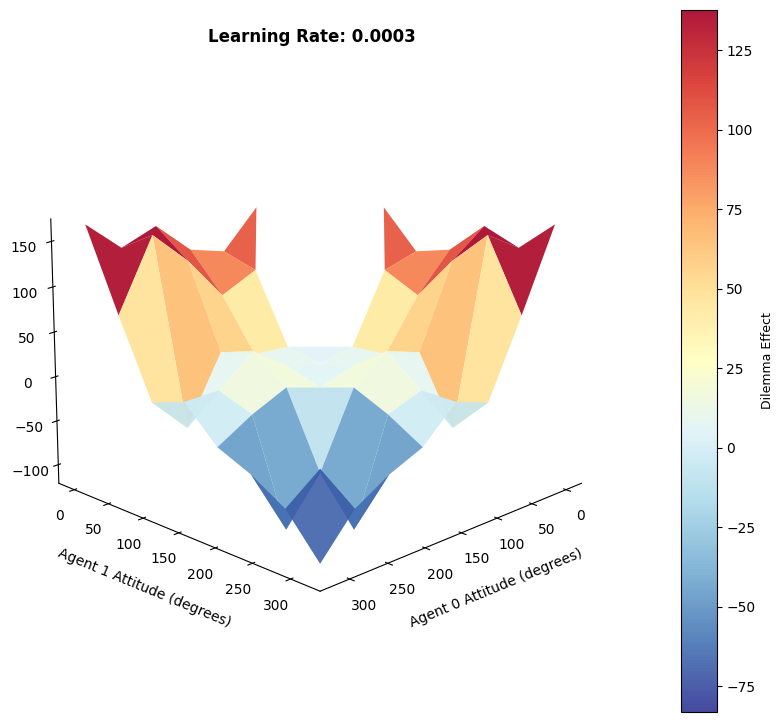

In [26]:
# 3D plot comparing dilemma effect vs agent attitudes (simplified version)
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Create a function to convert attitude coefficients to degrees
def attitude_to_degree(alpha, beta):
    """Convert attitude coefficients to degrees (0-360)"""
    if alpha == 0 and beta == 0:
        return 0
    return np.degrees(np.arctan2(beta, alpha)) % 360

# Add degree columns to the dataframe
df['attitude_degree_agent_0'] = df.apply(lambda row: attitude_to_degree(row['alpha_1'], row['beta_1']), axis=1)
df['attitude_degree_agent_1'] = df.apply(lambda row: attitude_to_degree(row['alpha_2'], row['beta_2']), axis=1)

# Calculate mean rewards for each combination of attitudes and dilemmas
comparison_data = []

for attitude in unique_attitudes:
    subset = df[df["attitude_key"] == attitude]
    
    # Get attitude degrees for this combination
    att_deg_0 = subset['attitude_degree_agent_0'].iloc[0]
    att_deg_1 = subset['attitude_degree_agent_1'].iloc[0]
    
    # Calculate mean rewards for each dilemma
    for lr in subset["lr"].unique():
        lr_subset = subset[subset["lr"] == lr]
        
        # Get mean rewards for each dilemma
        dilemma_0_mean = lr_subset[lr_subset["dilemma"] == 0]["pure_reward_total"].mean()
        dilemma_1_mean = lr_subset[lr_subset["dilemma"] == 1]["pure_reward_total"].mean()
        
        # Calculate difference (dilemma_1 - dilemma_0)
        dilemma_effect = dilemma_1_mean - dilemma_0_mean
        
        # Add the original data point
        comparison_data.append({
            'attitude_agent_0': att_deg_0,
            'attitude_agent_1': att_deg_1,
            'lr': lr,
            'dilemma_effect': dilemma_effect,
            'dilemma_0_mean': dilemma_0_mean,
            'dilemma_1_mean': dilemma_1_mean,
            'is_symmetric': False
        })
        
        # Add the symmetric data point (swap agents)
        comparison_data.append({
            'attitude_agent_0': att_deg_1,
            'attitude_agent_1': att_deg_0,
            'lr': lr,
            'dilemma_effect': dilemma_effect,  # Same effect due to symmetry
            'dilemma_0_mean': dilemma_0_mean,
            'dilemma_1_mean': dilemma_1_mean,
            'is_symmetric': True
        })

# Convert to DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Debug: Check what data we have
print("Available data:")
print(comparison_df[['attitude_agent_0', 'attitude_agent_1', 'lr', 'dilemma_effect']].head(10))
print(f"Total data points: {len(comparison_df)}")

# Create 3D plot with improved styling
fig = plt.figure(figsize=(16, 12))

# Create subplots for different learning rates
unique_lrs = comparison_df['lr'].unique()
n_lrs = len(unique_lrs)
cols = 2
rows = (n_lrs + 1) // 2

# Color maps for better distinction
color_maps = ['RdYlBu_r', 'viridis', 'plasma', 'coolwarm']

for i, lr in enumerate(unique_lrs):
    lr_data = comparison_df[comparison_df['lr'] == lr]
    
    print(f"Learning rate {lr}: {len(lr_data)} data points")
    
    ax = fig.add_subplot(rows, cols, i+1, projection='3d')
    
    # Create meshgrid for surface
    x_unique = sorted(lr_data['attitude_agent_0'].unique())
    y_unique = sorted(lr_data['attitude_agent_1'].unique())
    X, Y = np.meshgrid(x_unique, y_unique)
    
    # Create Z matrix
    Z = np.zeros_like(X)
    for i_x, x in enumerate(x_unique):
        for i_y, y in enumerate(y_unique):
            mask = (lr_data['attitude_agent_0'] == x) & (lr_data['attitude_agent_1'] == y)
            if mask.any():
                Z[i_y, i_x] = lr_data[mask]['dilemma_effect'].iloc[0]
            else:
                Z[i_y, i_x] = np.nan
    
    # Create surface plot with better colors
    surf = ax.plot_surface(X, Y, Z, cmap=color_maps[i % len(color_maps)], 
                          alpha=0.9, linewidth=0, antialiased=True)
    
    # Set axis orientation: x-axis going out from viewer (0 at right)
    ax.view_init(elev=20, azim=45)
    
    # Customize axis labels and limits
    ax.set_xlabel('Agent 0 Attitude (degrees)', fontsize=10, labelpad=10)
    ax.set_ylabel('Agent 1 Attitude (degrees)', fontsize=10, labelpad=10)
    ax.set_zlabel('Dilemma Effect\n(Dilemma=1 - Dilemma=0)', fontsize=10, labelpad=10)
    ax.set_title(f'Learning Rate: {lr}', fontsize=12, fontweight='bold', pad=20)
    
    # Add colorbar with better positioning
    cbar = fig.colorbar(surf, ax=ax, shrink=0.6, aspect=20, pad=0.1)
    cbar.set_label('Dilemma Effect', fontsize=9)
    
    # Remove grid lines for cleaner look
    ax.grid(False)
    
    # Set background color
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')

plt.tight_layout()
plt.show()

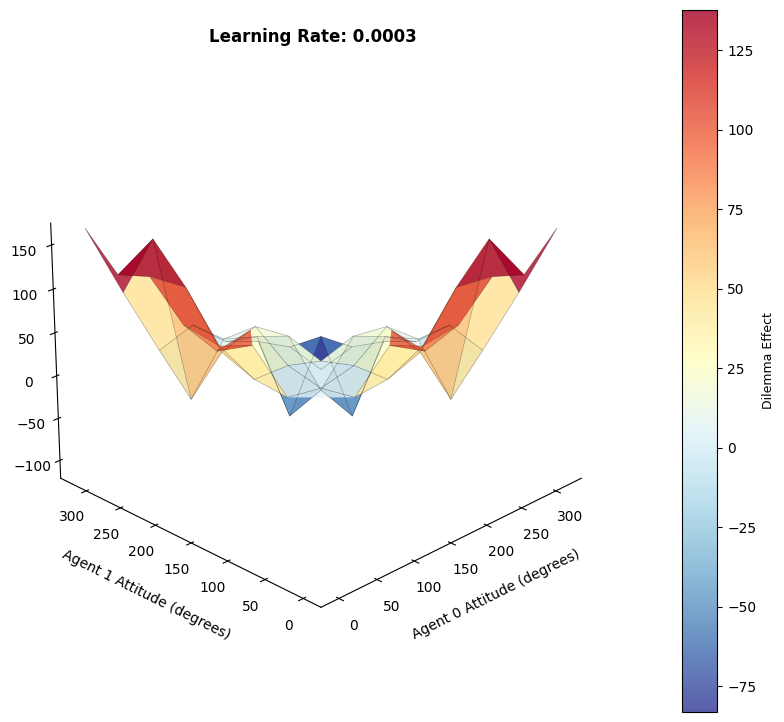

In [27]:
# 3D plot comparing dilemma effect vs agent attitudes (with contour lines and better angle)
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Create a function to convert attitude coefficients to degrees
def attitude_to_degree(alpha, beta):
    """Convert attitude coefficients to degrees (0-360)"""
    if alpha == 0 and beta == 0:
        return 0
    return np.degrees(np.arctan2(beta, alpha)) % 360

# Add degree columns to the dataframe
df['attitude_degree_agent_0'] = df.apply(lambda row: attitude_to_degree(row['alpha_1'], row['beta_1']), axis=1)
df['attitude_degree_agent_1'] = df.apply(lambda row: attitude_to_degree(row['alpha_2'], row['beta_2']), axis=1)

# Calculate mean rewards for each combination of attitudes and dilemmas
comparison_data = []

for attitude in unique_attitudes:
    subset = df[df["attitude_key"] == attitude]
    
    # Get attitude degrees for this combination
    att_deg_0 = subset['attitude_degree_agent_0'].iloc[0]
    att_deg_1 = subset['attitude_degree_agent_1'].iloc[0]
    
    # Calculate mean rewards for each dilemma
    for lr in subset["lr"].unique():
        lr_subset = subset[subset["lr"] == lr]
        
        # Get mean rewards for each dilemma
        dilemma_0_mean = lr_subset[lr_subset["dilemma"] == 0]["pure_reward_total"].mean()
        dilemma_1_mean = lr_subset[lr_subset["dilemma"] == 1]["pure_reward_total"].mean()
        
        # Calculate difference (dilemma_1 - dilemma_0)
        dilemma_effect = dilemma_1_mean - dilemma_0_mean
        
        # Add the original data point
        comparison_data.append({
            'attitude_agent_0': att_deg_0,
            'attitude_agent_1': att_deg_1,
            'lr': lr,
            'dilemma_effect': dilemma_effect,
            'dilemma_0_mean': dilemma_0_mean,
            'dilemma_1_mean': dilemma_1_mean,
            'is_symmetric': False
        })
        
        # Add the symmetric data point (swap agents)
        comparison_data.append({
            'attitude_agent_0': att_deg_1,
            'attitude_agent_1': att_deg_0,
            'lr': lr,
            'dilemma_effect': dilemma_effect,  # Same effect due to symmetry
            'dilemma_0_mean': dilemma_0_mean,
            'dilemma_1_mean': dilemma_1_mean,
            'is_symmetric': True
        })

# Convert to DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Create 3D plot with improved styling
fig = plt.figure(figsize=(16, 12))

# Create subplots for different learning rates
unique_lrs = comparison_df['lr'].unique()
n_lrs = len(unique_lrs)
cols = 2
rows = (n_lrs + 1) // 2

# Color maps for better distinction
color_maps = ['RdYlBu_r', 'viridis', 'plasma', 'coolwarm']

for i, lr in enumerate(unique_lrs):
    lr_data = comparison_df[comparison_df['lr'] == lr]
    
    ax = fig.add_subplot(rows, cols, i+1, projection='3d')
    
    # Create meshgrid for surface
    x_unique = sorted(lr_data['attitude_agent_0'].unique())
    y_unique = sorted(lr_data['attitude_agent_1'].unique())
    X, Y = np.meshgrid(x_unique, y_unique)
    
    # Create Z matrix
    Z = np.zeros_like(X)
    for i_x, x in enumerate(x_unique):
        for i_y, y in enumerate(y_unique):
            mask = (lr_data['attitude_agent_0'] == x) & (lr_data['attitude_agent_1'] == y)
            if mask.any():
                Z[i_y, i_x] = lr_data[mask]['dilemma_effect'].iloc[0]
            else:
                Z[i_y, i_x] = np.nan
    
    # Create surface plot with better colors and wireframe
    surf = ax.plot_surface(X, Y, Z, cmap=color_maps[i % len(color_maps)], 
                          alpha=0.8, linewidth=0, antialiased=True)
    
    # Add wireframe to show contours and direction
    wire = ax.plot_wireframe(X, Y, Z, color='black', alpha=0.3, linewidth=0.5)
    
    # Set better viewing angle (from side and above)
    ax.view_init(elev=25, azim=225)  # 25 degrees elevation, 225 degrees azimuth
    
    # Customize axis labels and limits
    ax.set_xlabel('Agent 0 Attitude (degrees)', fontsize=10, labelpad=10)
    ax.set_ylabel('Agent 1 Attitude (degrees)', fontsize=10, labelpad=10)
    ax.set_zlabel('Dilemma Effect\n(Dilemma=1 - Dilemma=0)', fontsize=10, labelpad=10)
    ax.set_title(f'Learning Rate: {lr}', fontsize=12, fontweight='bold', pad=20)
    
    # Add colorbar with better positioning
    cbar = fig.colorbar(surf, ax=ax, shrink=0.6, aspect=20, pad=0.1)
    cbar.set_label('Dilemma Effect', fontsize=9)
    
    # Remove grid lines for cleaner look
    ax.grid(False)
    
    # Set background color
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')

plt.tight_layout()
plt.show()

In [25]:
# Create a summary showing the symmetry
print("Summary of Dilemma Effects (including symmetric data):")
summary_table = comparison_df.groupby(['attitude_agent_0', 'attitude_agent_1'])['dilemma_effect'].agg(['mean', 'std', 'count']).round(3)
print(summary_table)

# Find the attitude combinations with the most positive and negative dilemma effects
print("\nAttitude combinations with strongest positive dilemma effect:")
positive_effects = comparison_df.groupby(['attitude_agent_0', 'attitude_agent_1'])['dilemma_effect'].mean().nlargest(10)
print(positive_effects)

print("\nAttitude combinations with strongest negative dilemma effect:")
negative_effects = comparison_df.groupby(['attitude_agent_0', 'attitude_agent_1'])['dilemma_effect'].mean().nsmallest(10)
print(negative_effects)

Summary of Dilemma Effects (including symmetric data):
                                      mean  std  count
attitude_agent_0 attitude_agent_1                     
0.0              90.0              132.710  NaN      1
                 135.0              93.500  NaN      1
                 180.0             106.706  NaN      1
                 225.0             144.553  NaN      1
                 270.0             131.611  NaN      1
                 315.0             168.522  NaN      1
45.0             90.0                  NaN  NaN      0
                 135.0              83.760  NaN      1
                 180.0              66.926  NaN      1
                 225.0             117.307  NaN      1
                 270.0             156.875  NaN      1
                 315.0              80.740  NaN      1
90.0             0.0               132.710  NaN      1
                 45.0                  NaN  NaN      0
                 90.0                  NaN  NaN      0
          

Data points:
    angle_diff  dilemma_effect  att_deg_0  att_deg_1
0        315.0         168.522      315.0        0.0
1        270.0          80.740      315.0       45.0
2          0.0        -107.752      315.0      315.0
3        225.0          -2.565      315.0       90.0
4         45.0         -63.186      315.0      270.0
5        180.0          11.296      315.0      135.0
6         90.0         -40.501      315.0      225.0
7        135.0         -24.598      315.0      180.0
8        270.0         131.611      270.0        0.0
9         90.0         132.710       90.0        0.0
10       225.0         156.875      270.0       45.0
11        45.0             NaN       90.0       45.0
12       180.0         -44.355      270.0       90.0
13         0.0         -34.229      270.0      270.0
14         0.0             NaN       90.0       90.0
15       135.0          10.667      270.0      135.0
16        45.0        -115.581      270.0      225.0
17        90.0          -2.432   

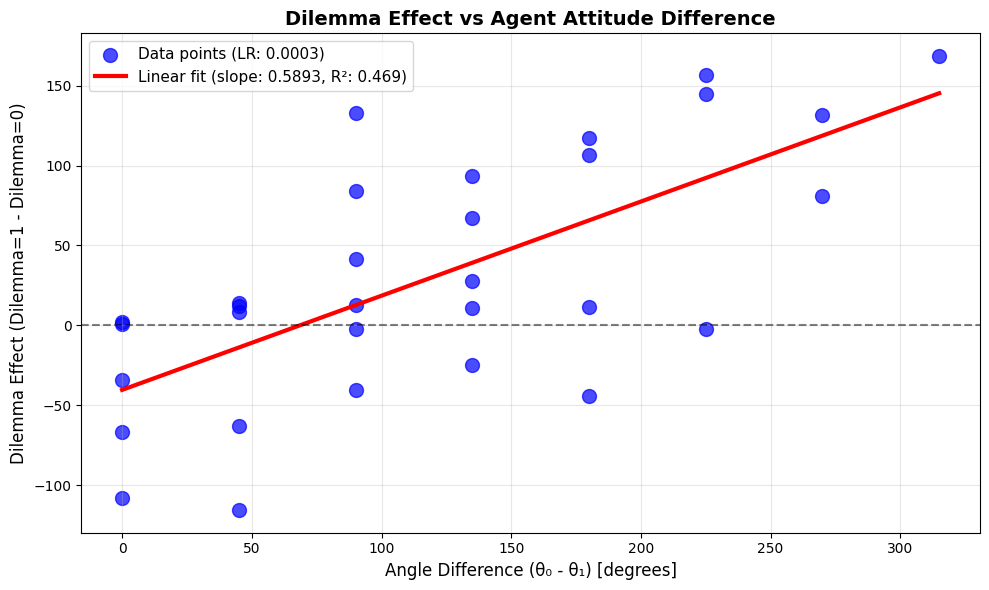


Summary by angle difference:
               mean     std  count
angle_diff                        
0.0         -41.139  46.909      5
45.0        -28.843  58.323      5
90.0         37.893  62.486      6
135.0        34.796  46.481      5
180.0        47.739  77.731      4
225.0        99.621  88.710      3
270.0       106.175  35.972      2
315.0       168.522     NaN      1


In [34]:
# 2D scatter plot: Dilemma effect vs angle difference with linear regression (single LR)
import numpy as np
from scipy import stats

# Create a function to convert attitude coefficients to degrees
def attitude_to_degree(alpha, beta):
    """Convert attitude coefficients to degrees (0-360)"""
    if alpha == 0 and beta == 0:
        return 0
    return np.degrees(np.arctan2(beta, alpha)) % 360

# Add degree columns to the dataframe
df['attitude_degree_agent_0'] = df.apply(lambda row: attitude_to_degree(row['alpha_1'], row['beta_1']), axis=1)
df['attitude_degree_agent_1'] = df.apply(lambda row: attitude_to_degree(row['alpha_2'], row['beta_2']), axis=1)

# Calculate mean rewards for each combination of attitudes and dilemmas
comparison_data = []

for attitude in unique_attitudes:
    subset = df[df["attitude_key"] == attitude]
    
    # Get attitude degrees for this combination
    att_deg_0 = subset['attitude_degree_agent_0'].iloc[0]
    att_deg_1 = subset['attitude_degree_agent_1'].iloc[0]
    
    # Calculate angle difference (theta_0 - theta_1)
    angle_diff = att_deg_0 - att_deg_1
    
    # Calculate mean rewards for each dilemma
    for lr in subset["lr"].unique():
        lr_subset = subset[subset["lr"] == lr]
        
        # Get mean rewards for each dilemma
        dilemma_0_mean = lr_subset[lr_subset["dilemma"] == 0]["pure_reward_total"].mean()
        dilemma_1_mean = lr_subset[lr_subset["dilemma"] == 1]["pure_reward_total"].mean()
        
        # Calculate difference (dilemma_1 - dilemma_0)
        dilemma_effect = dilemma_1_mean - dilemma_0_mean
        
        comparison_data.append({
            'angle_diff': angle_diff,
            'lr': lr,
            'dilemma_effect': dilemma_effect,
            'dilemma_0_mean': dilemma_0_mean,
            'dilemma_1_mean': dilemma_1_mean,
            'att_deg_0': att_deg_0,
            'att_deg_1': att_deg_1
        })

# Convert to DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Debug: Check the data
print("Data points:")
print(comparison_df[['angle_diff', 'dilemma_effect', 'att_deg_0', 'att_deg_1']].round(3))
print(f"Number of data points: {len(comparison_df)}")

# Create 2D scatter plot with linear regression
plt.figure(figsize=(10, 6))

# Get the single learning rate
lr = comparison_df['lr'].iloc[0]

# Scatter plot
plt.scatter(comparison_df['angle_diff'], comparison_df['dilemma_effect'], 
           s=100, alpha=0.7, color='blue', label=f'Data points (LR: {lr})')

# Linear regression - handle potential issues
try:
    # Remove any NaN values
    clean_data = comparison_df.dropna(subset=['angle_diff', 'dilemma_effect'])
    
    if len(clean_data) > 1:  # Need at least 2 points for regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(clean_data['angle_diff'], clean_data['dilemma_effect'])
        
        # Plot regression line
        x_range = np.linspace(clean_data['angle_diff'].min(), clean_data['angle_diff'].max(), 100)
        y_pred = slope * x_range + intercept
        plt.plot(x_range, y_pred, color='red', linewidth=3, 
                 label=f'Linear fit (slope: {slope:.4f}, R²: {r_value**2:.3f})')
        
        print(f"\nLinear Regression Results (Learning Rate: {lr}):")
        print(f"Slope: {slope:.6f}")
        print(f"Intercept: {intercept:.6f}")
        print(f"R-squared: {r_value**2:.6f}")
        print(f"P-value: {p_value:.6f}")
        print(f"Standard Error: {std_err:.6f}")
    else:
        print("Not enough data points for linear regression")
        
except Exception as e:
    print(f"Error in linear regression: {e}")
    print("Data for regression:")
    print(comparison_df[['angle_diff', 'dilemma_effect']])

plt.xlabel('Angle Difference (θ₀ - θ₁) [degrees]', fontsize=12)
plt.ylabel('Dilemma Effect (Dilemma=1 - Dilemma=0)', fontsize=12)
plt.title('Dilemma Effect vs Agent Attitude Difference', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Add a horizontal line at y=0 for reference
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.show()

# Print summary statistics
print(f"\nSummary by angle difference:")
summary_by_angle = comparison_df.groupby('angle_diff')['dilemma_effect'].agg(['mean', 'std', 'count']).round(3)
print(summary_by_angle)

In [33]:
print(comparison_df)

    angle_diff      lr  dilemma_effect  dilemma_0_mean  dilemma_1_mean  \
0        315.0  0.0003      168.521762      -93.305390       75.216372   
1        270.0  0.0003       80.739601      -49.916832       30.822770   
2          0.0  0.0003     -107.751881     -152.903168     -260.655050   
3        225.0  0.0003       -2.565471      -63.513341      -66.078812   
4         45.0  0.0003      -63.185941     -165.411683     -228.597624   
5        180.0  0.0003       11.295955      -89.455955      -78.160000   
6         90.0  0.0003      -40.500594     -139.503960     -180.004554   
7        135.0  0.0003      -24.598020      -82.058020     -106.656040   
8        270.0  0.0003      131.611089      -89.239406       42.371683   
9         90.0  0.0003      132.709505       60.711881      193.421386   
10       225.0  0.0003      156.874653      -28.620990      128.253663   
11        45.0  0.0003             NaN       85.501386             NaN   
12       180.0  0.0003      -44.354851

Data points:
    attitude_compatibility  dilemma_effect  alpha_1  beta_1  alpha_2  beta_2
0                   -0.707         168.522    0.707  -0.707    1.000   0.000
1                    0.000          80.740    0.707  -0.707    0.707   0.707
2                   -1.000        -107.752    0.707  -0.707    0.707  -0.707
3                    0.707          -2.565    0.707  -0.707    0.000   1.000
4                   -0.707         -63.186    0.707  -0.707   -0.000  -1.000
5                    1.000          11.296    0.707  -0.707   -0.707   0.707
6                    0.000         -40.501    0.707  -0.707   -0.707  -0.707
7                    0.707         -24.598    0.707  -0.707   -1.000   0.000
8                   -1.000         131.611   -0.000  -1.000    1.000   0.000
9                    1.000         132.710    0.000   1.000    1.000   0.000
10                  -0.707         156.875   -0.000  -1.000    0.707   0.707
11                   0.707             NaN    0.000   1.000    

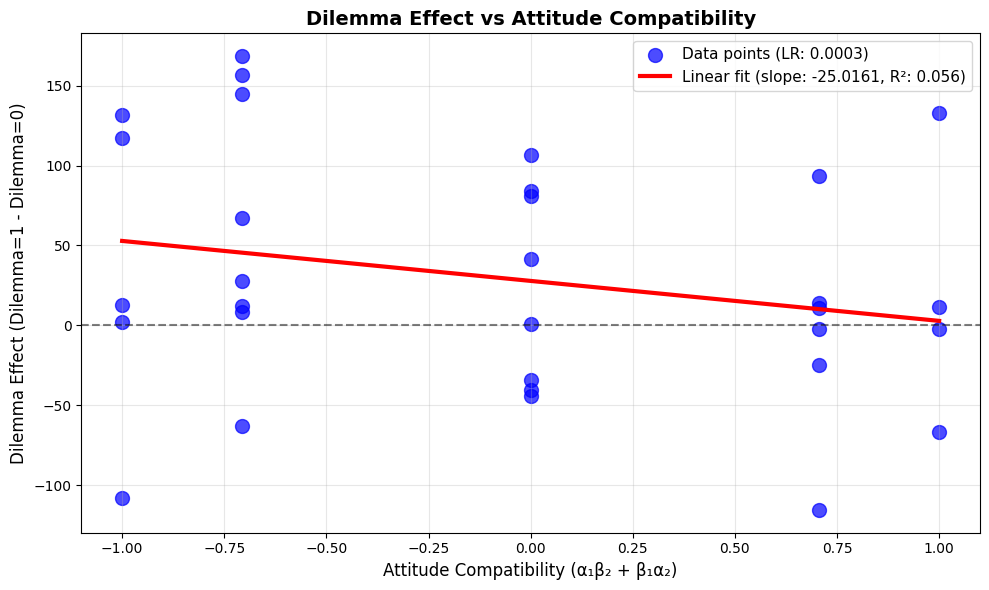


Summary by attitude compatibility:
                          mean      std  count
attitude_compatibility                        
-1.000001                3.939  112.539      3
-1.000000               72.054   84.227      2
-0.707107               65.199   83.955      8
 0.000000               24.296   61.744      8
 0.707107               -4.075   67.715      6
 1.000000               65.139   95.560      2
 1.000001              -27.804   55.296      2

Attitude compatibilities with strongest positive dilemma effect:
attitude_compatibility
-1.000000    72.053762
-0.707107    65.199181
 1.000000    65.138713
 0.000000    24.296435
-1.000001     3.939076
Name: dilemma_effect, dtype: float64

Attitude compatibilities with strongest negative dilemma effect:
attitude_compatibility
 1.000001   -27.804101
 0.707107    -4.074773
-1.000001     3.939076
 0.000000    24.296435
 1.000000    65.138713
Name: dilemma_effect, dtype: float64


In [35]:
# 2D scatter plot: Dilemma effect vs attitude compatibility with linear regression
import numpy as np
from scipy import stats

# Calculate attitude compatibility for each combination
comparison_data = []

for attitude in unique_attitudes:
    subset = df[df["attitude_key"] == attitude]
    
    # Get attitude coefficients for this combination
    alpha_1 = subset['alpha_1'].iloc[0]
    beta_1 = subset['beta_1'].iloc[0]
    alpha_2 = subset['alpha_2'].iloc[0]
    beta_2 = subset['beta_2'].iloc[0]
    
    # Calculate attitude compatibility: alpha_1*beta_2 + beta_1*alpha_2
    attitude_compatibility = alpha_1 * beta_2 + beta_1 * alpha_2
    
    # Calculate mean rewards for each dilemma
    for lr in subset["lr"].unique():
        lr_subset = subset[subset["lr"] == lr]
        
        # Get mean rewards for each dilemma
        dilemma_0_mean = lr_subset[lr_subset["dilemma"] == 0]["pure_reward_total"].mean()
        dilemma_1_mean = lr_subset[lr_subset["dilemma"] == 1]["pure_reward_total"].mean()
        
        # Calculate difference (dilemma_1 - dilemma_0)
        dilemma_effect = dilemma_1_mean - dilemma_0_mean
        
        comparison_data.append({
            'attitude_compatibility': attitude_compatibility,
            'lr': lr,
            'dilemma_effect': dilemma_effect,
            'dilemma_0_mean': dilemma_0_mean,
            'dilemma_1_mean': dilemma_1_mean,
            'alpha_1': alpha_1,
            'beta_1': beta_1,
            'alpha_2': alpha_2,
            'beta_2': beta_2
        })

# Convert to DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Debug: Check the data
print("Data points:")
print(comparison_df[['attitude_compatibility', 'dilemma_effect', 'alpha_1', 'beta_1', 'alpha_2', 'beta_2']].round(3))
print(f"Number of data points: {len(comparison_df)}")

# Create 2D scatter plot with linear regression
plt.figure(figsize=(10, 6))

# Get the single learning rate
lr = comparison_df['lr'].iloc[0]

# Scatter plot
plt.scatter(comparison_df['attitude_compatibility'], comparison_df['dilemma_effect'], 
           s=100, alpha=0.7, color='blue', label=f'Data points (LR: {lr})')

# Linear regression - handle potential issues
try:
    # Remove any NaN values
    clean_data = comparison_df.dropna(subset=['attitude_compatibility', 'dilemma_effect'])
    
    if len(clean_data) > 1:  # Need at least 2 points for regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(clean_data['attitude_compatibility'], clean_data['dilemma_effect'])
        
        # Plot regression line
        x_range = np.linspace(clean_data['attitude_compatibility'].min(), clean_data['attitude_compatibility'].max(), 100)
        y_pred = slope * x_range + intercept
        plt.plot(x_range, y_pred, color='red', linewidth=3, 
                 label=f'Linear fit (slope: {slope:.4f}, R²: {r_value**2:.3f})')
        
        print(f"\nLinear Regression Results (Learning Rate: {lr}):")
        print(f"Slope: {slope:.6f}")
        print(f"Intercept: {intercept:.6f}")
        print(f"R-squared: {r_value**2:.6f}")
        print(f"P-value: {p_value:.6f}")
        print(f"Standard Error: {std_err:.6f}")
    else:
        print("Not enough data points for linear regression")
        
except Exception as e:
    print(f"Error in linear regression: {e}")
    print("Data for regression:")
    print(comparison_df[['attitude_compatibility', 'dilemma_effect']])

plt.xlabel('Attitude Compatibility (α₁β₂ + β₁α₂)', fontsize=12)
plt.ylabel('Dilemma Effect (Dilemma=1 - Dilemma=0)', fontsize=12)
plt.title('Dilemma Effect vs Attitude Compatibility', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Add a horizontal line at y=0 for reference
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.show()

# Print summary statistics
print(f"\nSummary by attitude compatibility:")
summary_by_compatibility = comparison_df.groupby('attitude_compatibility')['dilemma_effect'].agg(['mean', 'std', 'count']).round(3)
print(summary_by_compatibility)

# Find the attitude compatibilities with strongest effects
print("\nAttitude compatibilities with strongest positive dilemma effect:")
positive_effects = comparison_df.groupby('attitude_compatibility')['dilemma_effect'].mean().nlargest(5)
print(positive_effects)

print("\nAttitude compatibilities with strongest negative dilemma effect:")
negative_effects = comparison_df.groupby('attitude_compatibility')['dilemma_effect'].mean().nsmallest(5)
print(negative_effects)

## Pure reward


Data points for Dilemma = 0:
    mean_pure_reward_abs  attitude_compatibility  alpha_1  beta_1  alpha_2  \
0                 93.305                  -0.707    0.707  -0.707    1.000   
2                 49.917                   0.000    0.707  -0.707    0.707   
4                152.903                  -1.000    0.707  -0.707    0.707   
6                 63.513                   0.707    0.707  -0.707    0.000   
8                165.412                  -0.707    0.707  -0.707   -0.000   
10                89.456                   1.000    0.707  -0.707   -0.707   
12               139.504                   0.000    0.707  -0.707   -0.707   
14                82.058                   0.707    0.707  -0.707   -1.000   
16                89.239                  -1.000   -0.000  -1.000    1.000   
18                60.712                   1.000    0.000   1.000    1.000   
20                28.621                  -0.707   -0.000  -1.000    0.707   
22                85.501          

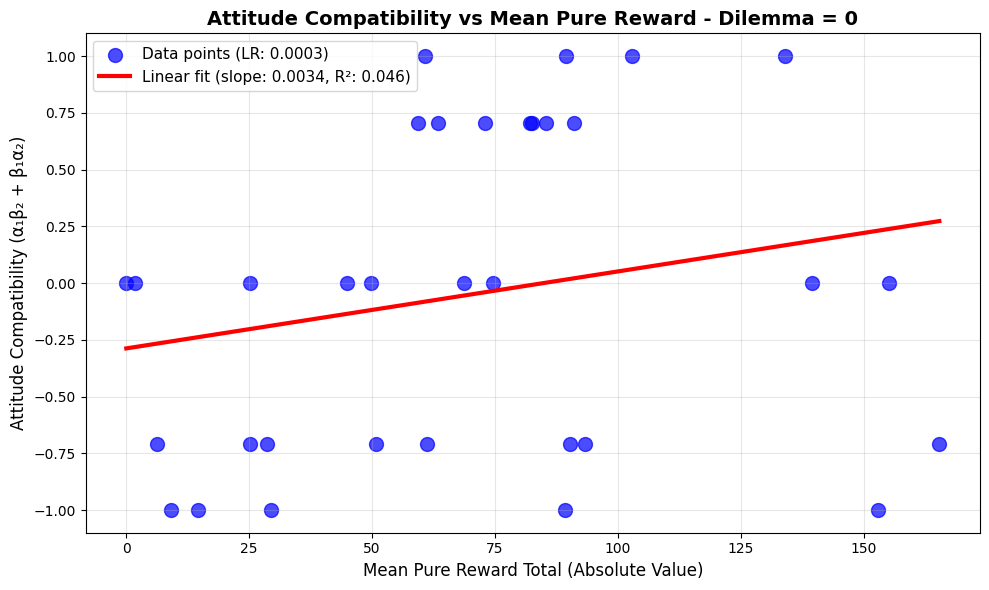


Summary by mean pure reward (absolute) for Dilemma = 0:
                       mean  std  count
mean_pure_reward_abs                   
0.048515              0.000  NaN      1
1.787129              0.000  NaN      1
6.367723             -0.707  NaN      1
9.233267             -1.000  NaN      1
14.534653            -1.000  NaN      1
25.139604             0.000  NaN      1
25.213267            -0.707  NaN      1
28.620990            -0.707  NaN      1
29.449901            -1.000  NaN      1
44.934059             0.000  NaN      1
49.916832             0.000  NaN      1
50.782970            -0.707  NaN      1
59.347525             0.707  NaN      1
60.711881             1.000  NaN      1
61.106733            -0.707  NaN      1
63.513341             0.707  NaN      1
68.676832             0.000  NaN      1
72.905941             0.707  NaN      1
74.652871             0.000  NaN      1
82.058020             0.707  NaN      1
82.553861             0.707  NaN      1
85.501386             0

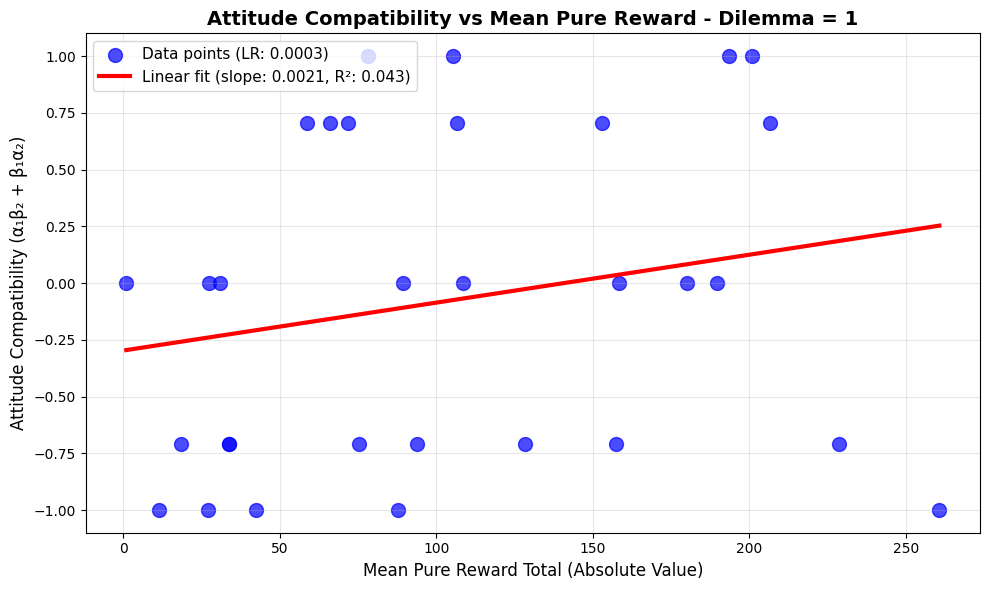


Summary by mean pure reward (absolute) for Dilemma = 1:
                       mean  std  count
mean_pure_reward_abs                   
0.974455              0.000  NaN      1
11.495050            -1.000  NaN      1
18.379604            -0.707  NaN      1
27.031089            -1.000  NaN      1
27.352673             0.000  NaN      1
30.822770             0.000  NaN      1
33.621584            -0.707  NaN      1
33.622772            -0.707  NaN      1
42.371683            -1.000  NaN      1
58.776238             0.707  NaN      1
66.078812             0.707  NaN      1
71.887327             0.707  NaN      1
75.216372            -0.707  NaN      1
78.160000             1.000  NaN      1
87.857426            -1.000  NaN      1
89.288911             0.000  NaN      1
93.769703            -0.707  NaN      1
105.431881            1.000  NaN      1
106.656040            0.707  NaN      1
108.493267            0.000  NaN      1
128.253663           -0.707  NaN      1
152.847525            0

In [39]:
# 2D scatter plots: Mean pure reward vs attitude compatibility for each dilemma separately
import numpy as np
from scipy import stats

# Calculate attitude compatibility and mean pure reward for each combination and dilemma
comparison_data = []

for attitude in unique_attitudes:
    subset = df[df["attitude_key"] == attitude]
    
    # Get attitude coefficients for this combination
    alpha_1 = subset['alpha_1'].iloc[0]
    beta_1 = subset['beta_1'].iloc[0]
    alpha_2 = subset['alpha_2'].iloc[0]
    beta_2 = subset['beta_2'].iloc[0]
    
    # Calculate attitude compatibility: alpha_1*beta_2 + beta_1*alpha_2
    attitude_compatibility = alpha_1 * beta_2 + beta_1 * alpha_2
    
    # Calculate mean rewards for each dilemma separately
    for lr in subset["lr"].unique():
        lr_subset = subset[subset["lr"] == lr]
        
        # Get mean pure reward for each dilemma separately
        for dilemma in [0, 1]:
            dilemma_subset = lr_subset[lr_subset["dilemma"] == dilemma]
            mean_pure_reward = abs(dilemma_subset["pure_reward_total"].mean())
            
            comparison_data.append({
                'mean_pure_reward_abs': mean_pure_reward,
                'lr': lr,
                'dilemma': dilemma,
                'attitude_compatibility': attitude_compatibility,
                'alpha_1': alpha_1,
                'beta_1': beta_1,
                'alpha_2': alpha_2,
                'beta_2': beta_2
            })

# Convert to DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Create separate plots for each dilemma
for dilemma in [0, 1]:
    # Filter data for this dilemma
    dilemma_data = comparison_df[comparison_df['dilemma'] == dilemma]
    
    # Debug: Check the data
    print(f"\nData points for Dilemma = {dilemma}:")
    print(dilemma_data[['mean_pure_reward_abs', 'attitude_compatibility', 'alpha_1', 'beta_1', 'alpha_2', 'beta_2']].round(3))
    print(f"Number of data points: {len(dilemma_data)}")
    
    # Create 2D scatter plot with linear regression
    plt.figure(figsize=(10, 6))
    
    # Get the single learning rate
    lr = dilemma_data['lr'].iloc[0]
    
    # Scatter plot
    plt.scatter(dilemma_data['mean_pure_reward_abs'], dilemma_data['attitude_compatibility'], 
               s=100, alpha=0.7, color='blue', label=f'Data points (LR: {lr})')
    
    # Linear regression - handle potential issues
    try:
        # Remove any NaN values
        clean_data = dilemma_data.dropna(subset=['mean_pure_reward_abs', 'attitude_compatibility'])
        
        if len(clean_data) > 1:  # Need at least 2 points for regression
            slope, intercept, r_value, p_value, std_err = stats.linregress(clean_data['mean_pure_reward_abs'], clean_data['attitude_compatibility'])
            
            # Plot regression line
            x_range = np.linspace(clean_data['mean_pure_reward_abs'].min(), clean_data['mean_pure_reward_abs'].max(), 100)
            y_pred = slope * x_range + intercept
            plt.plot(x_range, y_pred, color='red', linewidth=3, 
                     label=f'Linear fit (slope: {slope:.4f}, R²: {r_value**2:.3f})')
            
            print(f"\nLinear Regression Results for Dilemma = {dilemma} (Learning Rate: {lr}):")
            print(f"Slope: {slope:.6f}")
            print(f"Intercept: {intercept:.6f}")
            print(f"R-squared: {r_value**2:.6f}")
            print(f"P-value: {p_value:.6f}")
            print(f"Standard Error: {std_err:.6f}")
        else:
            print("Not enough data points for linear regression")
            
    except Exception as e:
        print(f"Error in linear regression: {e}")
        print("Data for regression:")
        print(dilemma_data[['mean_pure_reward_abs', 'attitude_compatibility']])
    
    plt.xlabel('Mean Pure Reward Total (Absolute Value)', fontsize=12)
    plt.ylabel('Attitude Compatibility (α₁β₂ + β₁α₂)', fontsize=12)
    plt.title(f'Attitude Compatibility vs Mean Pure Reward - Dilemma = {dilemma}', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    plt.show()
    
    # Print summary statistics for this dilemma
    print(f"\nSummary by mean pure reward (absolute) for Dilemma = {dilemma}:")
    summary_by_reward = dilemma_data.groupby('mean_pure_reward_abs')['attitude_compatibility'].agg(['mean', 'std', 'count']).round(3)
    print(summary_by_reward)
    
    # Find the rewards with highest and lowest attitude compatibility for this dilemma
    print(f"\nMean pure rewards with highest attitude compatibility (Dilemma = {dilemma}):")
    highest_compatibility = dilemma_data.groupby('mean_pure_reward_abs')['attitude_compatibility'].mean().nlargest(5)
    print(highest_compatibility)
    
    print(f"\nMean pure rewards with lowest attitude compatibility (Dilemma = {dilemma}):")
    lowest_compatibility = dilemma_data.groupby('mean_pure_reward_abs')['attitude_compatibility'].mean().nsmallest(5)
    print(lowest_compatibility)

# Also show comparison between dilemmas
print("\n" + "="*50)
print("COMPARISON BETWEEN DILEMMAS")
print("="*50)

for attitude in unique_attitudes:
    subset = df[df["attitude_key"] == attitude]
    alpha_1 = subset['alpha_1'].iloc[0]
    beta_1 = subset['beta_1'].iloc[0]
    alpha_2 = subset['alpha_2'].iloc[0]
    beta_2 = subset['beta_2'].iloc[0]
    attitude_compatibility = alpha_1 * beta_2 + beta_1 * alpha_2
    
    for lr in subset["lr"].unique():
        lr_subset = subset[subset["lr"] == lr]
        dilemma_0_mean = abs(lr_subset[lr_subset["dilemma"] == 0]["pure_reward_total"].mean())
        dilemma_1_mean = abs(lr_subset[lr_subset["dilemma"] == 1]["pure_reward_total"].mean())
        difference = dilemma_1_mean - dilemma_0_mean
        
        print(f"Attitude compatibility: {attitude_compatibility:.3f}, LR: {lr}")
        print(f"  Dilemma=0: {dilemma_0_mean:.3f}")
        print(f"  Dilemma=1: {dilemma_1_mean:.3f}")
        print(f"  Difference (1-0): {difference:.3f}")
        print()

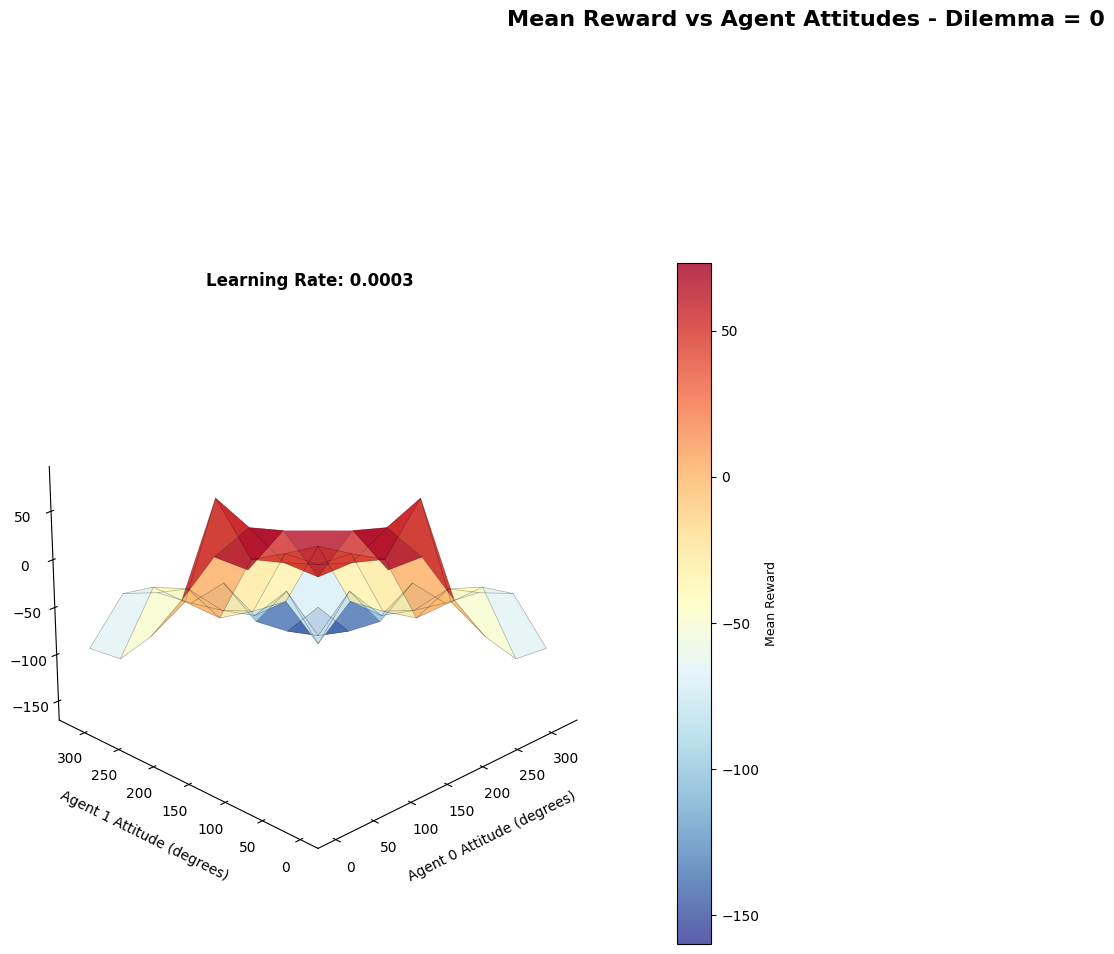


Summary of Mean Rewards for Dilemma = 0:
                                      mean  std  count
attitude_agent_0 attitude_agent_1                     
0.0              90.0               60.712  NaN      1
                 135.0              59.348  NaN      1
                 180.0               1.787  NaN      1
                 225.0             -50.783  NaN      1
                 270.0             -89.239  NaN      1
                 315.0             -93.305  NaN      1
45.0             90.0               85.501  NaN      1
                 135.0              74.653  NaN      1
                 180.0              90.321  NaN      1
                 225.0             -29.450  NaN      1
                 270.0             -28.621  NaN      1
                 315.0             -49.917  NaN      1
90.0             0.0                60.712  NaN      1
                 45.0               85.501  NaN      1
                 90.0               25.140  0.0      2
                 135.0 

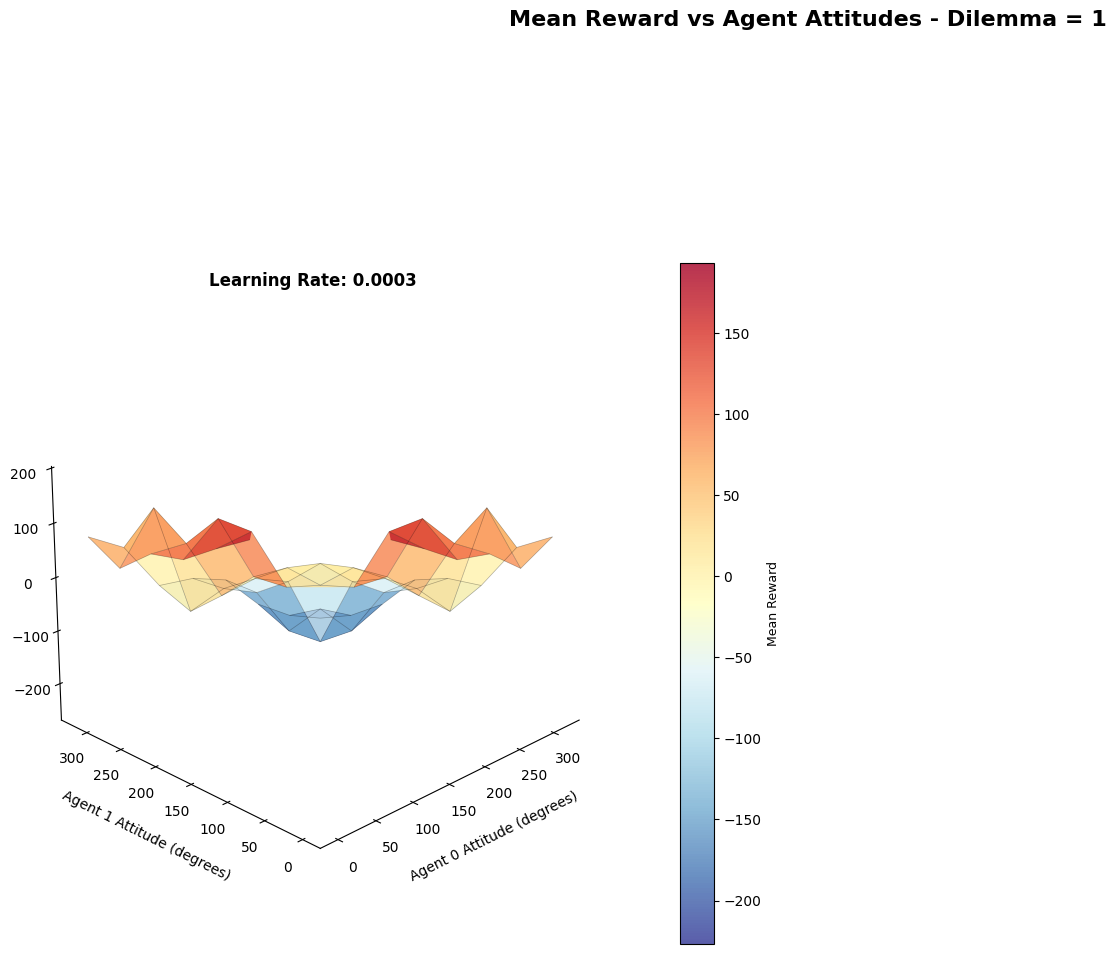


Summary of Mean Rewards for Dilemma = 1:
                                      mean  std  count
attitude_agent_0 attitude_agent_1                     
0.0              90.0              193.421  NaN      1
                 135.0             152.848  NaN      1
                 180.0             108.493  NaN      1
                 225.0              93.770  NaN      1
                 270.0              42.372  NaN      1
                 315.0              75.216  NaN      1
45.0             90.0                  NaN  NaN      0
                 135.0             158.413  NaN      1
                 180.0             157.247  NaN      1
                 225.0              87.857  NaN      1
                 270.0             128.254  NaN      1
                 315.0              30.823  NaN      1
90.0             0.0               193.421  NaN      1
                 45.0                  NaN  NaN      0
                 90.0                  NaN  NaN      0
                 135.0 

In [38]:
# 3D plots comparing mean reward vs agent attitudes for each dilemma separately
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Create a function to convert attitude coefficients to degrees
def attitude_to_degree(alpha, beta):
    """Convert attitude coefficients to degrees (0-360)"""
    if alpha == 0 and beta == 0:
        return 0
    return np.degrees(np.arctan2(beta, alpha)) % 360

# Add degree columns to the dataframe
df['attitude_degree_agent_0'] = df.apply(lambda row: attitude_to_degree(row['alpha_1'], row['beta_1']), axis=1)
df['attitude_degree_agent_1'] = df.apply(lambda row: attitude_to_degree(row['alpha_2'], row['beta_2']), axis=1)

# Calculate mean rewards for each combination of attitudes and dilemma
comparison_data = []

for attitude in unique_attitudes:
    subset = df[df["attitude_key"] == attitude]
    
    # Get attitude degrees for this combination
    att_deg_0 = subset['attitude_degree_agent_0'].iloc[0]
    att_deg_1 = subset['attitude_degree_agent_1'].iloc[0]
    
    # Calculate mean rewards for each learning rate and dilemma
    for lr in subset["lr"].unique():
        lr_subset = subset[subset["lr"] == lr]
        
        # Get mean reward for each dilemma separately
        for dilemma in [0, 1]:
            dilemma_subset = lr_subset[lr_subset["dilemma"] == dilemma]
            mean_reward = dilemma_subset["pure_reward_total"].mean()
            
            # Add the original data point
            comparison_data.append({
                'attitude_agent_0': att_deg_0,
                'attitude_agent_1': att_deg_1,
                'lr': lr,
                'dilemma': dilemma,
                'mean_reward': mean_reward,
                'is_symmetric': False
            })
            
            # Add the symmetric data point (swap agents)
            comparison_data.append({
                'attitude_agent_0': att_deg_1,
                'attitude_agent_1': att_deg_0,
                'lr': lr,
                'dilemma': dilemma,
                'mean_reward': mean_reward,  # Same reward due to symmetry
                'is_symmetric': True
            })

# Convert to DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Create separate plots for each dilemma
for dilemma in [0, 1]:
    # Filter data for this dilemma
    dilemma_data = comparison_df[comparison_df['dilemma'] == dilemma]
    
    # Create 3D plot with improved styling
    fig = plt.figure(figsize=(16, 12))
    
    # Create subplots for different learning rates
    unique_lrs = dilemma_data['lr'].unique()
    n_lrs = len(unique_lrs)
    cols = 2
    rows = (n_lrs + 1) // 2
    
    # Color maps for better distinction
    color_maps = ['RdYlBu_r', 'viridis', 'plasma', 'coolwarm']
    
    for i, lr in enumerate(unique_lrs):
        lr_data = dilemma_data[dilemma_data['lr'] == lr]
        
        ax = fig.add_subplot(rows, cols, i+1, projection='3d')
        
        # Create meshgrid for surface
        x_unique = sorted(lr_data['attitude_agent_0'].unique())
        y_unique = sorted(lr_data['attitude_agent_1'].unique())
        X, Y = np.meshgrid(x_unique, y_unique)
        
        # Create Z matrix
        Z = np.zeros_like(X)
        for i_x, x in enumerate(x_unique):
            for i_y, y in enumerate(y_unique):
                mask = (lr_data['attitude_agent_0'] == x) & (lr_data['attitude_agent_1'] == y)
                if mask.any():
                    Z[i_y, i_x] = lr_data[mask]['mean_reward'].iloc[0]
                else:
                    Z[i_y, i_x] = np.nan
        
        # Create surface plot with better colors and wireframe
        surf = ax.plot_surface(X, Y, Z, cmap=color_maps[i % len(color_maps)], 
                              alpha=0.8, linewidth=0, antialiased=True)
        
        # Add wireframe to show contours and direction
        wire = ax.plot_wireframe(X, Y, Z, color='black', alpha=0.3, linewidth=0.5)
        
        # Set better viewing angle (from side and above)
        ax.view_init(elev=25, azim=225)  # 25 degrees elevation, 225 degrees azimuth
        
        # Customize axis labels and limits
        ax.set_xlabel('Agent 0 Attitude (degrees)', fontsize=10, labelpad=10)
        ax.set_ylabel('Agent 1 Attitude (degrees)', fontsize=10, labelpad=10)
        ax.set_zlabel('Mean Pure Reward Total', fontsize=10, labelpad=10)
        ax.set_title(f'Learning Rate: {lr}', fontsize=12, fontweight='bold', pad=20)
        
        # Add colorbar with better positioning
        cbar = fig.colorbar(surf, ax=ax, shrink=0.6, aspect=20, pad=0.1)
        cbar.set_label('Mean Reward', fontsize=9)
        
        # Remove grid lines for cleaner look
        ax.grid(False)
        
        # Set background color
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        ax.xaxis.pane.set_edgecolor('w')
        ax.yaxis.pane.set_edgecolor('w')
        ax.zaxis.pane.set_edgecolor('w')
    
    plt.suptitle(f'Mean Reward vs Agent Attitudes - Dilemma = {dilemma}', fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics for this dilemma
    print(f"\nSummary of Mean Rewards for Dilemma = {dilemma}:")
    summary_table = dilemma_data.groupby(['attitude_agent_0', 'attitude_agent_1'])['mean_reward'].agg(['mean', 'std', 'count']).round(3)
    print(summary_table)
    
    # Find the attitude combinations with highest and lowest rewards for this dilemma
    print(f"\nAttitude combinations with highest mean reward (Dilemma = {dilemma}):")
    highest_rewards = dilemma_data.groupby(['attitude_agent_0', 'attitude_agent_1'])['mean_reward'].mean().nlargest(5)
    print(highest_rewards)
    
    print(f"\nAttitude combinations with lowest mean reward (Dilemma = {dilemma}):")
    lowest_rewards = dilemma_data.groupby(['attitude_agent_0', 'attitude_agent_1'])['mean_reward'].mean().nsmallest(5)
    print(lowest_rewards)

# Also show comparison between dilemmas
print("\n" + "="*50)
print("COMPARISON BETWEEN DILEMMAS")
print("="*50)

for attitude in unique_attitudes:
    subset = df[df["attitude_key"] == attitude]
    att_deg_0 = subset['attitude_degree_agent_0'].iloc[0]
    att_deg_1 = subset['attitude_degree_agent_1'].iloc[0]
    
    for lr in subset["lr"].unique():
        lr_subset = subset[subset["lr"] == lr]
        dilemma_0_mean = lr_subset[lr_subset["dilemma"] == 0]["pure_reward_total"].mean()
        dilemma_1_mean = lr_subset[lr_subset["dilemma"] == 1]["pure_reward_total"].mean()
        difference = dilemma_1_mean - dilemma_0_mean
        
        print(f"Attitudes ({att_deg_0:.1f}°, {att_deg_1:.1f}°), LR: {lr}")
        print(f"  Dilemma=0: {dilemma_0_mean:.3f}")
        print(f"  Dilemma=1: {dilemma_1_mean:.3f}")
        print(f"  Difference (1-0): {difference:.3f}")
        print()


Data points for Dilemma = 0:
    angle_diff  mean_reward  att_deg_0  att_deg_1
0        315.0      -93.305      315.0        0.0
2        270.0      -49.917      315.0       45.0
4          0.0     -152.903      315.0      315.0
6        225.0      -63.513      315.0       90.0
8         45.0     -165.412      315.0      270.0
10       180.0      -89.456      315.0      135.0
12        90.0     -139.504      315.0      225.0
14       135.0      -82.058      315.0      180.0
16       270.0      -89.239      270.0        0.0
18        90.0       60.712       90.0        0.0
20       225.0      -28.621      270.0       45.0
22        45.0       85.501       90.0       45.0
24       180.0      -44.934      270.0       90.0
26         0.0     -155.267      270.0      270.0
28         0.0       25.140       90.0       90.0
30       135.0      -82.554      270.0      135.0
32        45.0      -91.035      270.0      225.0
34        90.0     -103.000      270.0      180.0
36       225.0      

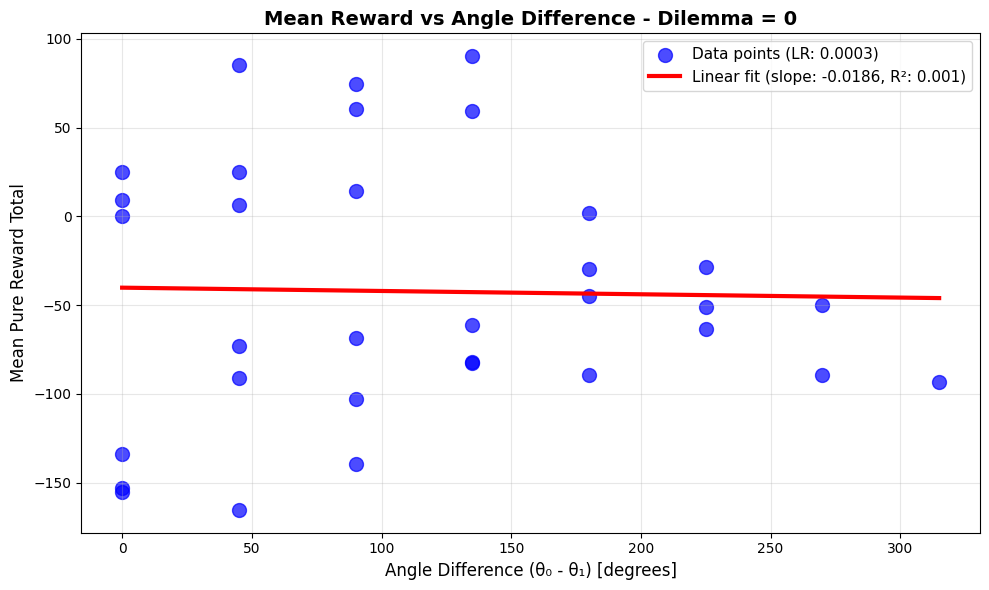


Summary by angle difference for Dilemma = 0:
              mean     std  count
angle_diff                       
0.0        -67.960  87.695      6
45.0       -35.378  91.039      6
90.0       -26.880  89.355      6
135.0      -15.210  83.376      5
180.0      -40.513  37.977      4
225.0      -47.639  17.657      3
270.0      -69.578  27.805      2
315.0      -93.305     NaN      1

Angle differences with highest mean reward (Dilemma = 0):
angle_diff
135.0   -15.210059
90.0    -26.880198
45.0    -35.378449
180.0   -40.513197
225.0   -47.639101
Name: mean_reward, dtype: float64

Angle differences with lowest mean reward (Dilemma = 0):
angle_diff
315.0   -93.305390
270.0   -69.578119
0.0     -67.960396
225.0   -47.639101
180.0   -40.513197
Name: mean_reward, dtype: float64

Data points for Dilemma = 1:
    angle_diff  mean_reward  att_deg_0  att_deg_1
1        315.0       75.216      315.0        0.0
3        270.0       30.823      315.0       45.0
5          0.0     -260.655      315.

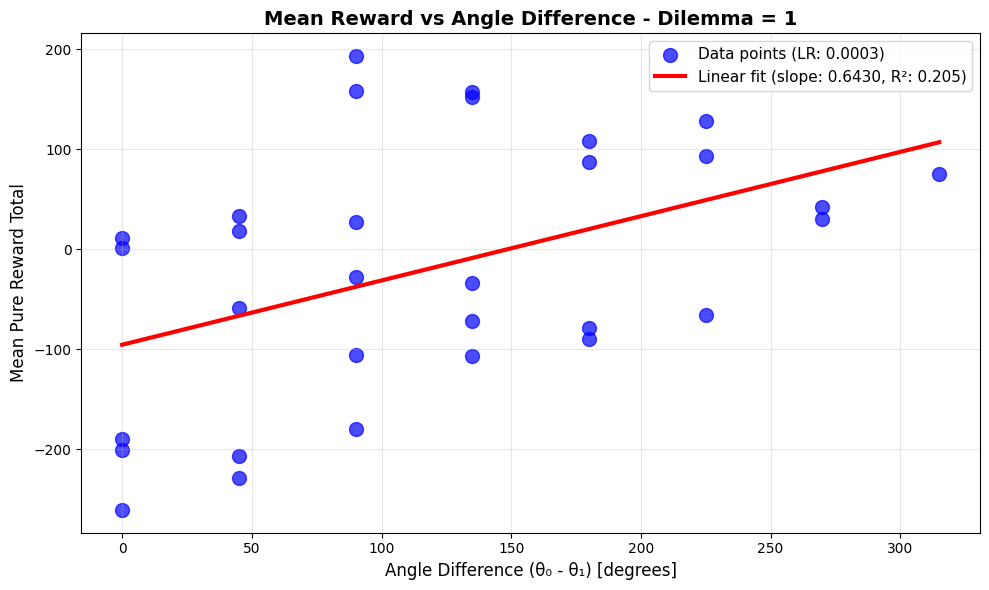


Summary by angle difference for Dilemma = 1:
               mean      std  count
angle_diff                         
0.0        -127.720  125.289      5
45.0        -88.398  123.288      5
90.0         11.013  146.134      6
135.0        19.586  126.338      5
180.0         7.225  105.455      4
225.0        51.982  103.687      3
270.0        36.597    8.166      2
315.0        75.216      NaN      1

Angle differences with highest mean reward (Dilemma = 1):
angle_diff
315.0    75.216372
225.0    51.981518
270.0    36.597226
135.0    19.585663
90.0     11.012673
Name: mean_reward, dtype: float64

Angle differences with lowest mean reward (Dilemma = 1):
angle_diff
0.0     -127.719802
45.0     -88.397901
180.0      7.225446
90.0      11.012673
135.0     19.585663
Name: mean_reward, dtype: float64

COMPARISON BETWEEN DILEMMAS
Angle difference: 315.0° (θ₀=315.0°, θ₁=0.0°), LR: 0.0003
  Dilemma=0: -93.305
  Dilemma=1: 75.216
  Difference (1-0): 168.522

Angle difference: 270.0° (θ₀=315.0°

In [40]:
# 2D scatter plot: Mean reward vs angle difference with linear regression
import numpy as np
from scipy import stats

# Create a function to convert attitude coefficients to degrees
def attitude_to_degree(alpha, beta):
    """Convert attitude coefficients to degrees (0-360)"""
    if alpha == 0 and beta == 0:
        return 0
    return np.degrees(np.arctan2(beta, alpha)) % 360

# Add degree columns to the dataframe
df['attitude_degree_agent_0'] = df.apply(lambda row: attitude_to_degree(row['alpha_1'], row['beta_1']), axis=1)
df['attitude_degree_agent_1'] = df.apply(lambda row: attitude_to_degree(row['alpha_2'], row['beta_2']), axis=1)

# Calculate mean rewards for each combination of attitudes and dilemma
comparison_data = []

for attitude in unique_attitudes:
    subset = df[df["attitude_key"] == attitude]
    
    # Get attitude degrees for this combination
    att_deg_0 = subset['attitude_degree_agent_0'].iloc[0]
    att_deg_1 = subset['attitude_degree_agent_1'].iloc[0]
    
    # Calculate angle difference (theta_0 - theta_1)
    angle_diff = att_deg_0 - att_deg_1
    
    # Calculate mean rewards for each dilemma separately
    for lr in subset["lr"].unique():
        lr_subset = subset[subset["lr"] == lr]
        
        # Get mean reward for each dilemma separately
        for dilemma in [0, 1]:
            dilemma_subset = lr_subset[lr_subset["dilemma"] == dilemma]
            mean_reward = dilemma_subset["pure_reward_total"].mean()
            
            comparison_data.append({
                'angle_diff': angle_diff,
                'lr': lr,
                'dilemma': dilemma,
                'mean_reward': mean_reward,
                'att_deg_0': att_deg_0,
                'att_deg_1': att_deg_1
            })

# Convert to DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Create separate plots for each dilemma
for dilemma in [0, 1]:
    # Filter data for this dilemma
    dilemma_data = comparison_df[comparison_df['dilemma'] == dilemma]
    
    # Debug: Check the data
    print(f"\nData points for Dilemma = {dilemma}:")
    print(dilemma_data[['angle_diff', 'mean_reward', 'att_deg_0', 'att_deg_1']].round(3))
    print(f"Number of data points: {len(dilemma_data)}")
    
    # Create 2D scatter plot with linear regression
    plt.figure(figsize=(10, 6))
    
    # Get the single learning rate
    lr = dilemma_data['lr'].iloc[0]
    
    # Scatter plot
    plt.scatter(dilemma_data['angle_diff'], dilemma_data['mean_reward'], 
               s=100, alpha=0.7, color='blue', label=f'Data points (LR: {lr})')
    
    # Linear regression - handle potential issues
    try:
        # Remove any NaN values
        clean_data = dilemma_data.dropna(subset=['angle_diff', 'mean_reward'])
        
        if len(clean_data) > 1:  # Need at least 2 points for regression
            slope, intercept, r_value, p_value, std_err = stats.linregress(clean_data['angle_diff'], clean_data['mean_reward'])
            
            # Plot regression line
            x_range = np.linspace(clean_data['angle_diff'].min(), clean_data['angle_diff'].max(), 100)
            y_pred = slope * x_range + intercept
            plt.plot(x_range, y_pred, color='red', linewidth=3, 
                     label=f'Linear fit (slope: {slope:.4f}, R²: {r_value**2:.3f})')
            
            print(f"\nLinear Regression Results for Dilemma = {dilemma} (Learning Rate: {lr}):")
            print(f"Slope: {slope:.6f}")
            print(f"Intercept: {intercept:.6f}")
            print(f"R-squared: {r_value**2:.6f}")
            print(f"P-value: {p_value:.6f}")
            print(f"Standard Error: {std_err:.6f}")
        else:
            print("Not enough data points for linear regression")
            
    except Exception as e:
        print(f"Error in linear regression: {e}")
        print("Data for regression:")
        print(dilemma_data[['angle_diff', 'mean_reward']])
    
    plt.xlabel('Angle Difference (θ₀ - θ₁) [degrees]', fontsize=12)
    plt.ylabel('Mean Pure Reward Total', fontsize=12)
    plt.title(f'Mean Reward vs Angle Difference - Dilemma = {dilemma}', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    plt.show()
    
    # Print summary statistics for this dilemma
    print(f"\nSummary by angle difference for Dilemma = {dilemma}:")
    summary_by_angle = dilemma_data.groupby('angle_diff')['mean_reward'].agg(['mean', 'std', 'count']).round(3)
    print(summary_by_angle)
    
    # Find the angle differences with highest and lowest rewards for this dilemma
    print(f"\nAngle differences with highest mean reward (Dilemma = {dilemma}):")
    highest_rewards = dilemma_data.groupby('angle_diff')['mean_reward'].mean().nlargest(5)
    print(highest_rewards)
    
    print(f"\nAngle differences with lowest mean reward (Dilemma = {dilemma}):")
    lowest_rewards = dilemma_data.groupby('angle_diff')['mean_reward'].mean().nsmallest(5)
    print(lowest_rewards)

# Also show comparison between dilemmas
print("\n" + "="*50)
print("COMPARISON BETWEEN DILEMMAS")
print("="*50)

for attitude in unique_attitudes:
    subset = df[df["attitude_key"] == attitude]
    att_deg_0 = subset['attitude_degree_agent_0'].iloc[0]
    att_deg_1 = subset['attitude_degree_agent_1'].iloc[0]
    angle_diff = att_deg_0 - att_deg_1
    
    for lr in subset["lr"].unique():
        lr_subset = subset[subset["lr"] == lr]
        dilemma_0_mean = lr_subset[lr_subset["dilemma"] == 0]["pure_reward_total"].mean()
        dilemma_1_mean = lr_subset[lr_subset["dilemma"] == 1]["pure_reward_total"].mean()
        difference = dilemma_1_mean - dilemma_0_mean
        
        print(f"Angle difference: {angle_diff:.1f}° (θ₀={att_deg_0:.1f}°, θ₁={att_deg_1:.1f}°), LR: {lr}")
        print(f"  Dilemma=0: {dilemma_0_mean:.3f}")
        print(f"  Dilemma=1: {dilemma_1_mean:.3f}")
        print(f"  Difference (1-0): {difference:.3f}")
        print()

## Coherence and strength of attitudes


Data points for Dilemma = 0:
     agent_angle  mean_modified_reward  agent_id  alpha   beta
0          315.0                29.350         0  0.707 -0.707
1            0.0               -67.406         1  1.000  0.000
4          315.0               179.049         0  0.707 -0.707
5           45.0               -35.297         1  0.707  0.707
8          315.0                46.749         0  0.707 -0.707
..           ...                   ...       ...    ...    ...
121         90.0                 6.385         1  0.000  1.000
124        180.0                -0.740         0 -1.000  0.000
125        135.0                -3.457         1 -0.707  0.707
128        180.0                 1.016         0 -1.000  0.000
129        180.0                -1.064         1 -1.000  0.000

[66 rows x 5 columns]
Number of data points: 66

Linear Regression Results for Dilemma = 0 (Learning Rate: 0.0003):
Slope: 0.295827
Intercept: 20.056946
R-squared: 0.143455
P-value: 0.001713
Standard Error: 0.0903

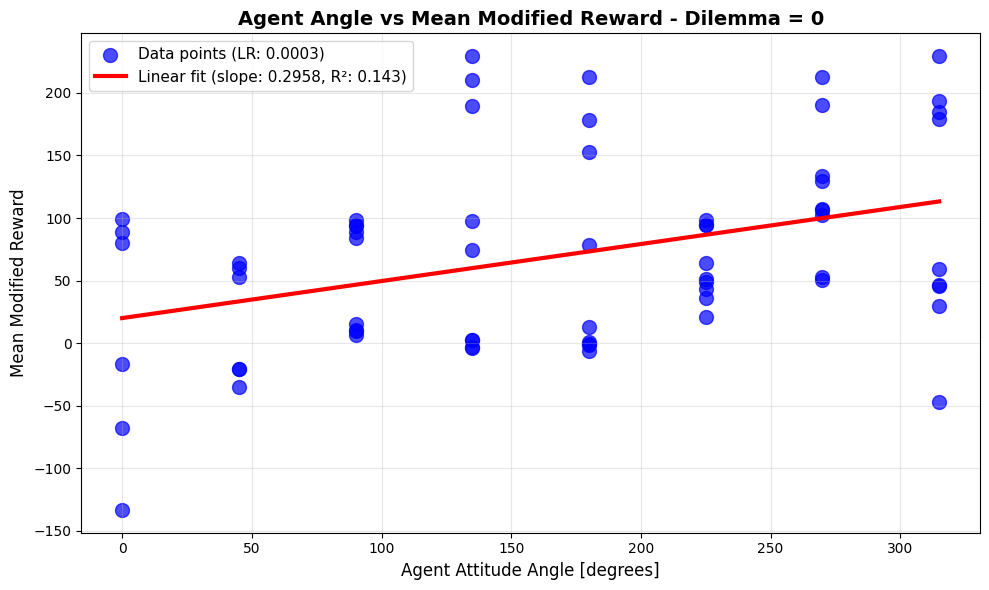


Summary by agent angle for Dilemma = 0:
                mean     std  count
agent_angle                        
0.0            8.449  96.135      6
45.0          16.792  46.729      6
90.0          55.764  43.079      9
135.0         88.945  97.948      9
180.0         69.683  88.604      9
225.0         61.400  28.528      9
270.0        120.491  54.383      9
315.0        102.278  95.445      9

Agent angles with highest mean modified reward (Dilemma = 0):
agent_angle
270.0    120.490693
315.0    102.278184
135.0     88.944910
180.0     69.683366
225.0     61.399572
Name: mean_modified_reward, dtype: float64

Agent angles with lowest mean modified reward (Dilemma = 0):
agent_angle
0.0       8.449352
45.0     16.792298
90.0     55.764268
225.0    61.399572
180.0    69.683366
Name: mean_modified_reward, dtype: float64

Data points for Dilemma = 1:
     agent_angle  mean_modified_reward  agent_id  alpha   beta
2          315.0               114.690         0  0.707 -0.707
3            

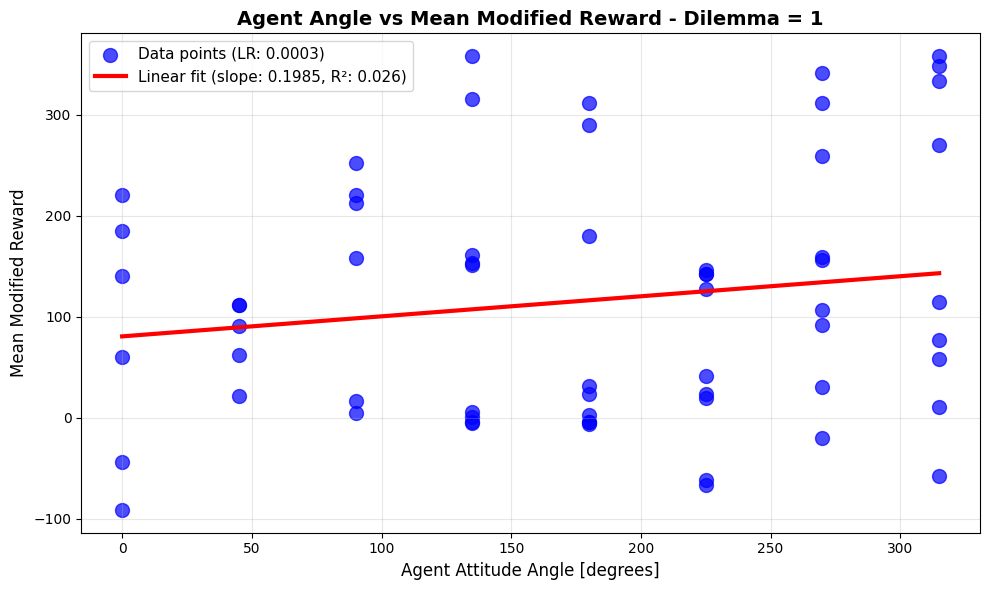


Summary by agent angle for Dilemma = 1:
                mean      std  count
agent_angle                         
0.0           78.379  126.042      6
45.0          79.563   38.139      5
90.0         144.119  108.175      6
135.0        126.076  139.990      9
180.0         91.577  131.800      9
225.0         57.086   86.246      9
270.0        159.412  123.795      9
315.0        168.083  160.227      9

Agent angles with highest mean modified reward (Dilemma = 1):
agent_angle
315.0    168.082548
270.0    159.411573
90.0     144.118977
135.0    126.076226
180.0     91.576920
Name: mean_modified_reward, dtype: float64

Agent angles with lowest mean modified reward (Dilemma = 1):
agent_angle
225.0     57.085623
0.0       78.379296
45.0      79.562757
180.0     91.576920
135.0    126.076226
Name: mean_modified_reward, dtype: float64

COMPARISON BETWEEN DILEMMAS
Agent 0 (θ=315.0°), LR: 0.0003
  Dilemma=0: 29.350
  Dilemma=1: 114.690
  Difference (1-0): 85.340

Agent 1 (θ=0.0°), LR: 0.0

In [41]:
# 2D scatter plot: Agent angle vs mean modified reward
import numpy as np
from scipy import stats

# Create a function to convert attitude coefficients to degrees
def attitude_to_degree(alpha, beta):
    """Convert attitude coefficients to degrees (0-360)"""
    if alpha == 0 and beta == 0:
        return 0
    return np.degrees(np.arctan2(beta, alpha)) % 360

# Add degree columns to the dataframe
df['attitude_degree_agent_0'] = df.apply(lambda row: attitude_to_degree(row['alpha_1'], row['beta_1']), axis=1)
df['attitude_degree_agent_1'] = df.apply(lambda row: attitude_to_degree(row['alpha_2'], row['beta_2']), axis=1)

# Calculate mean modified rewards for each agent angle
comparison_data = []

for attitude in unique_attitudes:
    subset = df[df["attitude_key"] == attitude]
    
    # Get attitude degrees for this combination
    att_deg_0 = subset['attitude_degree_agent_0'].iloc[0]
    att_deg_1 = subset['attitude_degree_agent_1'].iloc[0]
    
    # Calculate mean rewards for each learning rate and dilemma
    for lr in subset["lr"].unique():
        lr_subset = subset[subset["lr"] == lr]
        
        # Get mean modified reward for each dilemma separately
        for dilemma in [0, 1]:
            dilemma_subset = lr_subset[lr_subset["dilemma"] == dilemma]
            
            # Get mean modified rewards for each agent
            mean_modified_reward_agent_0 = dilemma_subset["modified_reward_agent_0"].mean()
            mean_modified_reward_agent_1 = dilemma_subset["modified_reward_agent_1"].mean()
            
            # Add data for agent 0
            comparison_data.append({
                'agent_angle': att_deg_0,
                'lr': lr,
                'dilemma': dilemma,
                'mean_modified_reward': mean_modified_reward_agent_0,
                'agent_id': 0,
                'alpha': subset['alpha_1'].iloc[0],
                'beta': subset['beta_1'].iloc[0]
            })
            
            # Add data for agent 1
            comparison_data.append({
                'agent_angle': att_deg_1,
                'lr': lr,
                'dilemma': dilemma,
                'mean_modified_reward': mean_modified_reward_agent_1,
                'agent_id': 1,
                'alpha': subset['alpha_2'].iloc[0],
                'beta': subset['beta_2'].iloc[0]
            })

# Convert to DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Create separate plots for each dilemma
for dilemma in [0, 1]:
    # Filter data for this dilemma
    dilemma_data = comparison_df[comparison_df['dilemma'] == dilemma]
    
    # Debug: Check the data
    print(f"\nData points for Dilemma = {dilemma}:")
    print(dilemma_data[['agent_angle', 'mean_modified_reward', 'agent_id', 'alpha', 'beta']].round(3))
    print(f"Number of data points: {len(dilemma_data)}")
    
    # Create 2D scatter plot with linear regression
    plt.figure(figsize=(10, 6))
    
    # Get the single learning rate
    lr = dilemma_data['lr'].iloc[0]
    
    # Scatter plot
    plt.scatter(dilemma_data['agent_angle'], dilemma_data['mean_modified_reward'], 
               s=100, alpha=0.7, color='blue', label=f'Data points (LR: {lr})')
    
    # Linear regression - handle potential issues
    try:
        # Remove any NaN values
        clean_data = dilemma_data.dropna(subset=['agent_angle', 'mean_modified_reward'])
        
        if len(clean_data) > 1:  # Need at least 2 points for regression
            slope, intercept, r_value, p_value, std_err = stats.linregress(clean_data['agent_angle'], clean_data['mean_modified_reward'])
            
            # Plot regression line
            x_range = np.linspace(clean_data['agent_angle'].min(), clean_data['agent_angle'].max(), 100)
            y_pred = slope * x_range + intercept
            plt.plot(x_range, y_pred, color='red', linewidth=3, 
                     label=f'Linear fit (slope: {slope:.4f}, R²: {r_value**2:.3f})')
            
            print(f"\nLinear Regression Results for Dilemma = {dilemma} (Learning Rate: {lr}):")
            print(f"Slope: {slope:.6f}")
            print(f"Intercept: {intercept:.6f}")
            print(f"R-squared: {r_value**2:.6f}")
            print(f"P-value: {p_value:.6f}")
            print(f"Standard Error: {std_err:.6f}")
        else:
            print("Not enough data points for linear regression")
            
    except Exception as e:
        print(f"Error in linear regression: {e}")
        print("Data for regression:")
        print(dilemma_data[['agent_angle', 'mean_modified_reward']])
    
    plt.xlabel('Agent Attitude Angle [degrees]', fontsize=12)
    plt.ylabel('Mean Modified Reward', fontsize=12)
    plt.title(f'Agent Angle vs Mean Modified Reward - Dilemma = {dilemma}', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    plt.show()
    
    # Print summary statistics for this dilemma
    print(f"\nSummary by agent angle for Dilemma = {dilemma}:")
    summary_by_angle = dilemma_data.groupby('agent_angle')['mean_modified_reward'].agg(['mean', 'std', 'count']).round(3)
    print(summary_by_angle)
    
    # Find the angles with highest and lowest rewards for this dilemma
    print(f"\nAgent angles with highest mean modified reward (Dilemma = {dilemma}):")
    highest_rewards = dilemma_data.groupby('agent_angle')['mean_modified_reward'].mean().nlargest(5)
    print(highest_rewards)
    
    print(f"\nAgent angles with lowest mean modified reward (Dilemma = {dilemma}):")
    lowest_rewards = dilemma_data.groupby('agent_angle')['mean_modified_reward'].mean().nsmallest(5)
    print(lowest_rewards)

# Also show comparison between dilemmas
print("\n" + "="*50)
print("COMPARISON BETWEEN DILEMMAS")
print("="*50)

for attitude in unique_attitudes:
    subset = df[df["attitude_key"] == attitude]
    att_deg_0 = subset['attitude_degree_agent_0'].iloc[0]
    att_deg_1 = subset['attitude_degree_agent_1'].iloc[0]
    
    for lr in subset["lr"].unique():
        lr_subset = subset[subset["lr"] == lr]
        
        # Get modified rewards for each agent and dilemma
        dilemma_0_agent_0 = lr_subset[lr_subset["dilemma"] == 0]["modified_reward_agent_0"].mean()
        dilemma_1_agent_0 = lr_subset[lr_subset["dilemma"] == 1]["modified_reward_agent_0"].mean()
        dilemma_0_agent_1 = lr_subset[lr_subset["dilemma"] == 0]["modified_reward_agent_1"].mean()
        dilemma_1_agent_1 = lr_subset[lr_subset["dilemma"] == 1]["modified_reward_agent_1"].mean()
        
        print(f"Agent 0 (θ={att_deg_0:.1f}°), LR: {lr}")
        print(f"  Dilemma=0: {dilemma_0_agent_0:.3f}")
        print(f"  Dilemma=1: {dilemma_1_agent_0:.3f}")
        print(f"  Difference (1-0): {dilemma_1_agent_0 - dilemma_0_agent_0:.3f}")
        print()
        
        print(f"Agent 1 (θ={att_deg_1:.1f}°), LR: {lr}")
        print(f"  Dilemma=0: {dilemma_0_agent_1:.3f}")
        print(f"  Dilemma=1: {dilemma_1_agent_1:.3f}")
        print(f"  Difference (1-0): {dilemma_1_agent_1 - dilemma_0_agent_1:.3f}")
        print()


Data points for Dilemma = 0:
     attitude_compatibility  mean_modified_reward  agent_id  alpha_1  beta_1  \
0                    -0.707                29.350         0    0.707  -0.707   
1                    -0.707               -67.406         1    0.707  -0.707   
4                     0.000               179.049         0    0.707  -0.707   
5                     0.000               -35.297         1    0.707  -0.707   
8                    -1.000                46.749         0    0.707  -0.707   
..                      ...                   ...       ...      ...     ...   
121                  -1.000                 6.385         1   -1.000   0.000   
124                  -0.707                -0.740         0   -1.000   0.000   
125                  -0.707                -3.457         1   -1.000   0.000   
128                  -0.000                 1.016         0   -1.000   0.000   
129                  -0.000                -1.064         1   -1.000   0.000   

     alph

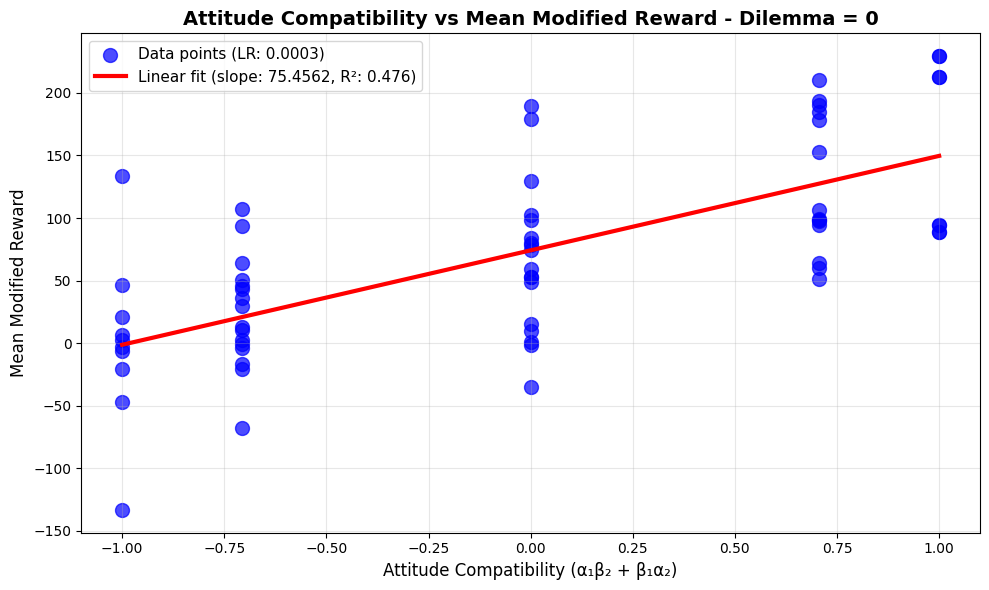


Summary by attitude compatibility for Dilemma = 0:
                           mean      std  count
attitude_compatibility                         
-1.000001                 0.000   32.411      6
-1.000000                 0.000  108.943      4
-0.707107                24.193   44.074     16
 0.000000                67.722   59.664     18
 0.707107               127.286   55.406     14
 1.000000               150.523   71.481      4
 1.000001               162.082   77.735      4

Attitude compatibilities with highest mean modified reward (Dilemma = 0):
attitude_compatibility
 1.000001    162.082008
 1.000000    150.523168
 0.707107    127.285638
 0.000000     67.722025
-0.707107     24.192672
Name: mean_modified_reward, dtype: float64

Attitude compatibilities with lowest mean modified reward (Dilemma = 0):
attitude_compatibility
-1.000001      0.000000
-1.000000      0.000000
-0.707107     24.192672
 0.000000     67.722025
 0.707107    127.285638
Name: mean_modified_reward, dtype: flo

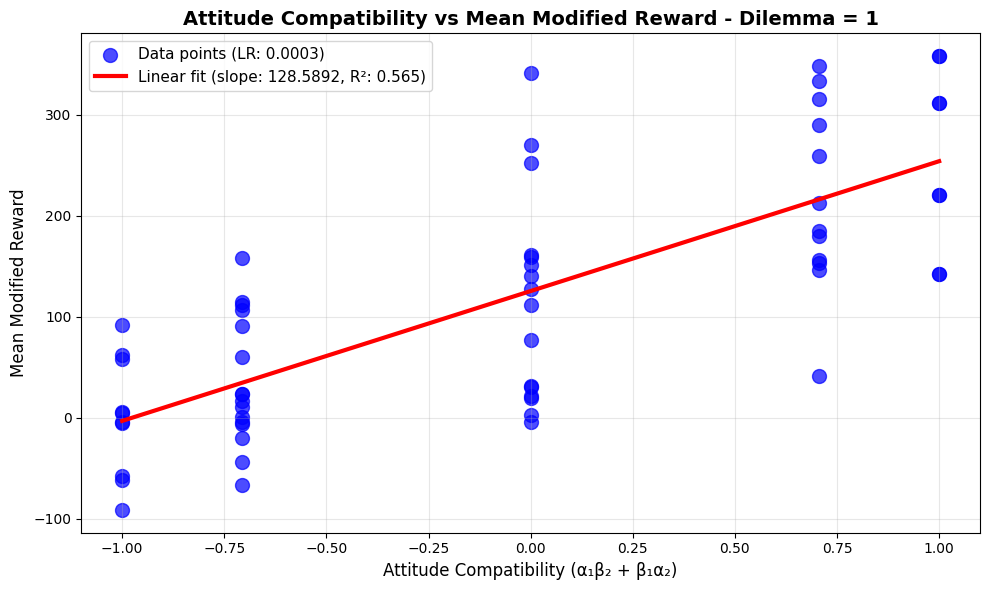


Summary by attitude compatibility for Dilemma = 1:
                           mean      std  count
attitude_compatibility                         
-1.000001                 0.000   53.885      6
-1.000000                 0.000   74.751      4
-0.707107                35.983   63.877     16
 0.000000               118.348  103.401     16
 0.707107               218.241   92.213     12
 1.000000               266.088   52.102      4
 1.000001               250.090  124.731      4

Attitude compatibilities with highest mean modified reward (Dilemma = 1):
attitude_compatibility
 1.000000    266.088119
 1.000001    250.090154
 0.707107    218.241289
 0.000000    118.347579
-0.707107     35.983100
Name: mean_modified_reward, dtype: float64

Attitude compatibilities with lowest mean modified reward (Dilemma = 1):
attitude_compatibility
-1.000001      0.000000
-1.000000      0.000000
-0.707107     35.983100
 0.000000    118.347579
 0.707107    218.241289
Name: mean_modified_reward, dtype: flo

In [42]:
# 2D scatter plot: Attitude compatibility vs mean modified reward
import numpy as np
from scipy import stats

# Calculate attitude compatibility and mean modified reward for each combination
comparison_data = []

for attitude in unique_attitudes:
    subset = df[df["attitude_key"] == attitude]
    
    # Get attitude coefficients for this combination
    alpha_1 = subset['alpha_1'].iloc[0]
    beta_1 = subset['beta_1'].iloc[0]
    alpha_2 = subset['alpha_2'].iloc[0]
    beta_2 = subset['beta_2'].iloc[0]
    
    # Calculate attitude compatibility: alpha_1*beta_2 + beta_1*alpha_2
    attitude_compatibility = alpha_1 * beta_2 + beta_1 * alpha_2
    
    # Calculate mean rewards for each learning rate and dilemma
    for lr in subset["lr"].unique():
        lr_subset = subset[subset["lr"] == lr]
        
        # Get mean modified reward for each dilemma separately
        for dilemma in [0, 1]:
            dilemma_subset = lr_subset[lr_subset["dilemma"] == dilemma]
            
            # Get mean modified rewards for each agent
            mean_modified_reward_agent_0 = dilemma_subset["modified_reward_agent_0"].mean()
            mean_modified_reward_agent_1 = dilemma_subset["modified_reward_agent_1"].mean()
            
            # Add data for agent 0
            comparison_data.append({
                'attitude_compatibility': attitude_compatibility,
                'lr': lr,
                'dilemma': dilemma,
                'mean_modified_reward': mean_modified_reward_agent_0,
                'agent_id': 0,
                'alpha_1': alpha_1,
                'beta_1': beta_1,
                'alpha_2': alpha_2,
                'beta_2': beta_2
            })
            
            # Add data for agent 1
            comparison_data.append({
                'attitude_compatibility': attitude_compatibility,
                'lr': lr,
                'dilemma': dilemma,
                'mean_modified_reward': mean_modified_reward_agent_1,
                'agent_id': 1,
                'alpha_1': alpha_1,
                'beta_1': beta_1,
                'alpha_2': alpha_2,
                'beta_2': beta_2
            })

# Convert to DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Create separate plots for each dilemma
for dilemma in [0, 1]:
    # Filter data for this dilemma
    dilemma_data = comparison_df[comparison_df['dilemma'] == dilemma]
    
    # Debug: Check the data
    print(f"\nData points for Dilemma = {dilemma}:")
    print(dilemma_data[['attitude_compatibility', 'mean_modified_reward', 'agent_id', 'alpha_1', 'beta_1', 'alpha_2', 'beta_2']].round(3))
    print(f"Number of data points: {len(dilemma_data)}")
    
    # Create 2D scatter plot with linear regression
    plt.figure(figsize=(10, 6))
    
    # Get the single learning rate
    lr = dilemma_data['lr'].iloc[0]
    
    # Scatter plot
    plt.scatter(dilemma_data['attitude_compatibility'], dilemma_data['mean_modified_reward'], 
               s=100, alpha=0.7, color='blue', label=f'Data points (LR: {lr})')
    
    # Linear regression - handle potential issues
    try:
        # Remove any NaN values
        clean_data = dilemma_data.dropna(subset=['attitude_compatibility', 'mean_modified_reward'])
        
        if len(clean_data) > 1:  # Need at least 2 points for regression
            slope, intercept, r_value, p_value, std_err = stats.linregress(clean_data['attitude_compatibility'], clean_data['mean_modified_reward'])
            
            # Plot regression line
            x_range = np.linspace(clean_data['attitude_compatibility'].min(), clean_data['attitude_compatibility'].max(), 100)
            y_pred = slope * x_range + intercept
            plt.plot(x_range, y_pred, color='red', linewidth=3, 
                     label=f'Linear fit (slope: {slope:.4f}, R²: {r_value**2:.3f})')
            
            print(f"\nLinear Regression Results for Dilemma = {dilemma} (Learning Rate: {lr}):")
            print(f"Slope: {slope:.6f}")
            print(f"Intercept: {intercept:.6f}")
            print(f"R-squared: {r_value**2:.6f}")
            print(f"P-value: {p_value:.6f}")
            print(f"Standard Error: {std_err:.6f}")
        else:
            print("Not enough data points for linear regression")
            
    except Exception as e:
        print(f"Error in linear regression: {e}")
        print("Data for regression:")
        print(dilemma_data[['attitude_compatibility', 'mean_modified_reward']])
    
    plt.xlabel('Attitude Compatibility (α₁β₂ + β₁α₂)', fontsize=12)
    plt.ylabel('Mean Modified Reward', fontsize=12)
    plt.title(f'Attitude Compatibility vs Mean Modified Reward - Dilemma = {dilemma}', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    plt.show()
    
    # Print summary statistics for this dilemma
    print(f"\nSummary by attitude compatibility for Dilemma = {dilemma}:")
    summary_by_compatibility = dilemma_data.groupby('attitude_compatibility')['mean_modified_reward'].agg(['mean', 'std', 'count']).round(3)
    print(summary_by_compatibility)
    
    # Find the compatibilities with highest and lowest rewards for this dilemma
    print(f"\nAttitude compatibilities with highest mean modified reward (Dilemma = {dilemma}):")
    highest_rewards = dilemma_data.groupby('attitude_compatibility')['mean_modified_reward'].mean().nlargest(5)
    print(highest_rewards)
    
    print(f"\nAttitude compatibilities with lowest mean modified reward (Dilemma = {dilemma}):")
    lowest_rewards = dilemma_data.groupby('attitude_compatibility')['mean_modified_reward'].mean().nsmallest(5)
    print(lowest_rewards)

# Also show comparison between dilemmas
print("\n" + "="*50)
print("COMPARISON BETWEEN DILEMMAS")
print("="*50)

for attitude in unique_attitudes:
    subset = df[df["attitude_key"] == attitude]
    alpha_1 = subset['alpha_1'].iloc[0]
    beta_1 = subset['beta_1'].iloc[0]
    alpha_2 = subset['alpha_2'].iloc[0]
    beta_2 = subset['beta_2'].iloc[0]
    attitude_compatibility = alpha_1 * beta_2 + beta_1 * alpha_2
    
    for lr in subset["lr"].unique():
        lr_subset = subset[subset["lr"] == lr]
        
        # Get modified rewards for each agent and dilemma
        dilemma_0_agent_0 = lr_subset[lr_subset["dilemma"] == 0]["modified_reward_agent_0"].mean()
        dilemma_1_agent_0 = lr_subset[lr_subset["dilemma"] == 1]["modified_reward_agent_0"].mean()
        dilemma_0_agent_1 = lr_subset[lr_subset["dilemma"] == 0]["modified_reward_agent_1"].mean()
        dilemma_1_agent_1 = lr_subset[lr_subset["dilemma"] == 1]["modified_reward_agent_1"].mean()
        
        print(f"Attitude compatibility: {attitude_compatibility:.3f}, LR: {lr}")
        print(f"  Agent 0 - Dilemma=0: {dilemma_0_agent_0:.3f}")
        print(f"  Agent 0 - Dilemma=1: {dilemma_1_agent_0:.3f}")
        print(f"  Agent 0 - Difference (1-0): {dilemma_1_agent_0 - dilemma_0_agent_0:.3f}")
        print(f"  Agent 1 - Dilemma=0: {dilemma_0_agent_1:.3f}")
        print(f"  Agent 1 - Dilemma=1: {dilemma_1_agent_1:.3f}")
        print(f"  Agent 1 - Difference (1-0): {dilemma_1_agent_1 - dilemma_0_agent_1:.3f}")
        print()

ATTITUDE STRENGTH RANKING (by mean modified reward)
Rank | Attitude (α, β) | Degree | Mean Reward | Min Reward | Max Reward | Std Dev
--------------------------------------------------------------------------------
   1 | (-0.000, -1.000) |  270.0° |    139.951 |    -20.576 |    341.723 |  92.219
   2 | (0.707, -0.707) |  315.0° |    135.180 |    -58.079 |    358.110 | 128.613
   3 | (-0.707, 0.707) |  135.0° |    107.511 |     -5.135 |    358.110 | 115.406
   4 | (-1.000, 0.000) |  180.0° |     80.630 |     -6.385 |    311.210 | 106.441
   5 | (-0.707, -0.707) |  225.0° |     59.243 |    -66.305 |    146.100 |  60.600
   6 | (1.000, 0.000) |    0.0° |     43.414 |   -133.274 |    220.966 | 108.133
   7 | (0.707, 0.707) |   45.0° |        nan |        nan |        nan |     nan
   8 | (0.000, 1.000) |   90.0° |        nan |        nan |        nan |     nan

ATTITUDE RESILIENCE RANKING (by minimum modified reward)
Rank | Attitude (α, β) | Degree | Min Reward | Mean Reward | Max Reward 

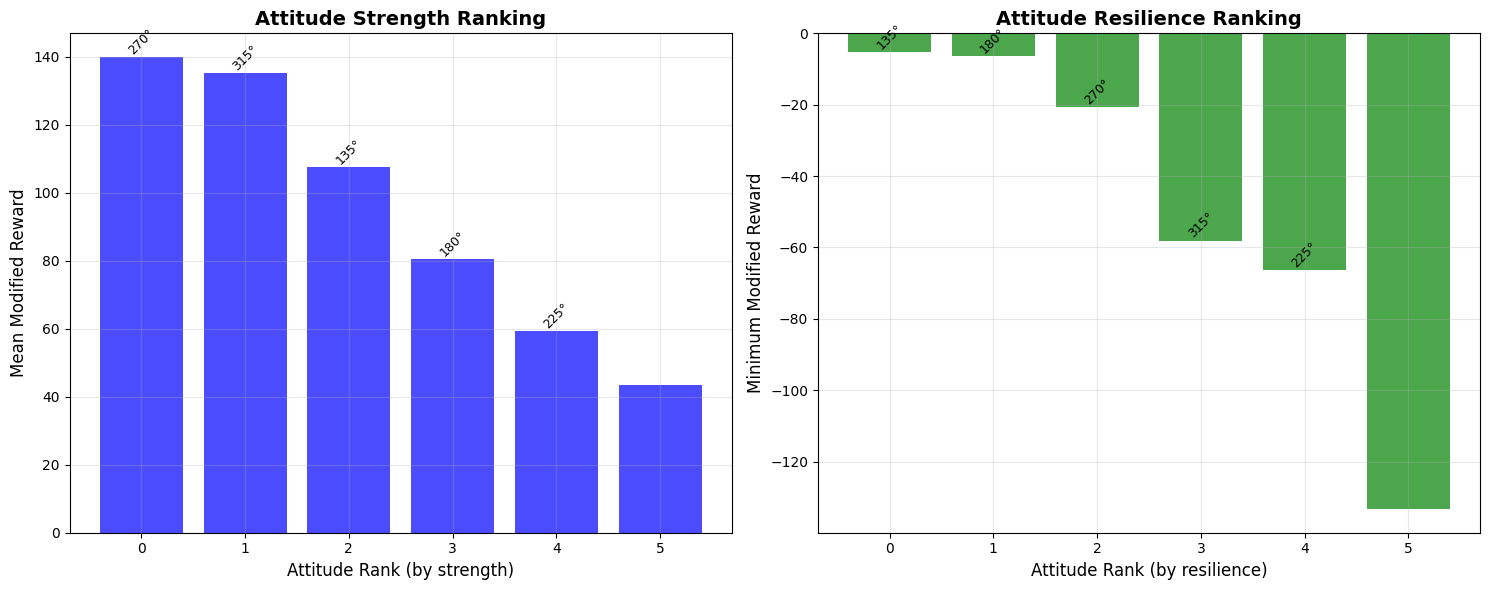


ADDITIONAL ANALYSIS
Total unique attitudes analyzed: 8
Attitude with highest mean reward: (-0.000, -1.000) (270.0°)
Attitude with highest minimum reward: (-0.707, 0.707) (135.0°)
Correlation between strength and resilience: nan

Attitudes that are both strong and resilient (top 25% in both):


In [43]:
# Calculate attitude strength and resilience based on modified rewards
import numpy as np

# Create a function to convert attitude coefficients to degrees
def attitude_to_degree(alpha, beta):
    """Convert attitude coefficients to degrees (0-360)"""
    if alpha == 0 and beta == 0:
        return 0
    return np.degrees(np.arctan2(beta, alpha)) % 360

# Add degree columns to the dataframe
df['attitude_degree_agent_0'] = df.apply(lambda row: attitude_to_degree(row['alpha_1'], row['beta_1']), axis=1)
df['attitude_degree_agent_1'] = df.apply(lambda row: attitude_to_degree(row['alpha_2'], row['beta_2']), axis=1)

# Calculate modified rewards for each attitude across all combinations
attitude_performance = {}

for attitude in unique_attitudes:
    subset = df[df["attitude_key"] == attitude]
    
    # Get attitude coefficients for this combination
    alpha_1 = subset['alpha_1'].iloc[0]
    beta_1 = subset['beta_1'].iloc[0]
    alpha_2 = subset['alpha_2'].iloc[0]
    beta_2 = subset['beta_2'].iloc[0]
    
    # Calculate attitude degrees
    att_deg_0 = subset['attitude_degree_agent_0'].iloc[0]
    att_deg_1 = subset['attitude_degree_agent_1'].iloc[0]
    
    # Calculate mean rewards for each learning rate and dilemma
    for lr in subset["lr"].unique():
        lr_subset = subset[subset["lr"] == lr]
        
        # Get mean modified reward for each dilemma separately
        for dilemma in [0, 1]:
            dilemma_subset = lr_subset[lr_subset["dilemma"] == dilemma]
            
            # Get mean modified rewards for each agent
            mean_modified_reward_agent_0 = dilemma_subset["modified_reward_agent_0"].mean()
            mean_modified_reward_agent_1 = dilemma_subset["modified_reward_agent_1"].mean()
            
            # Store data for agent 0 attitude
            att_key_0 = f"({alpha_1:.3f}, {beta_1:.3f})"
            if att_key_0 not in attitude_performance:
                attitude_performance[att_key_0] = {
                    'alpha': alpha_1,
                    'beta': beta_1,
                    'degree': att_deg_0,
                    'rewards': []
                }
            attitude_performance[att_key_0]['rewards'].append(mean_modified_reward_agent_0)
            
            # Store data for agent 1 attitude
            att_key_1 = f"({alpha_2:.3f}, {beta_2:.3f})"
            if att_key_1 not in attitude_performance:
                attitude_performance[att_key_1] = {
                    'alpha': alpha_2,
                    'beta': beta_2,
                    'degree': att_deg_1,
                    'rewards': []
                }
            attitude_performance[att_key_1]['rewards'].append(mean_modified_reward_agent_1)

# Calculate statistics for each attitude
attitude_stats = []
for att_key, data in attitude_performance.items():
    rewards = np.array(data['rewards'])
    
    attitude_stats.append({
        'attitude': att_key,
        'alpha': data['alpha'],
        'beta': data['beta'],
        'degree': data['degree'],
        'mean_reward': np.mean(rewards),
        'min_reward': np.min(rewards),
        'max_reward': np.max(rewards),
        'std_reward': np.std(rewards),
        'num_combinations': len(rewards)
    })

# Convert to DataFrame
attitude_df = pd.DataFrame(attitude_stats)

# Sort by mean reward (strength) - highest first
strength_ranking = attitude_df.sort_values('mean_reward', ascending=False)

# Sort by minimum reward (resilience) - highest first
resilience_ranking = attitude_df.sort_values('min_reward', ascending=False)

# Display results
print("="*60)
print("ATTITUDE STRENGTH RANKING (by mean modified reward)")
print("="*60)
print("Rank | Attitude (α, β) | Degree | Mean Reward | Min Reward | Max Reward | Std Dev")
print("-" * 80)

for i, (_, row) in enumerate(strength_ranking.iterrows(), 1):
    print(f"{i:4d} | {row['attitude']:12s} | {row['degree']:6.1f}° | {row['mean_reward']:10.3f} | {row['min_reward']:10.3f} | {row['max_reward']:10.3f} | {row['std_reward']:7.3f}")

print("\n" + "="*60)
print("ATTITUDE RESILIENCE RANKING (by minimum modified reward)")
print("="*60)
print("Rank | Attitude (α, β) | Degree | Min Reward | Mean Reward | Max Reward | Std Dev")
print("-" * 80)

for i, (_, row) in enumerate(resilience_ranking.iterrows(), 1):
    print(f"{i:4d} | {row['attitude']:12s} | {row['degree']:6.1f}° | {row['min_reward']:10.3f} | {row['mean_reward']:10.3f} | {row['max_reward']:10.3f} | {row['std_reward']:7.3f}")

# Create visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Strength ranking plot
ax1.bar(range(len(strength_ranking)), strength_ranking['mean_reward'], color='blue', alpha=0.7)
ax1.set_xlabel('Attitude Rank (by strength)', fontsize=12)
ax1.set_ylabel('Mean Modified Reward', fontsize=12)
ax1.set_title('Attitude Strength Ranking', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Add attitude labels for top 5
for i in range(min(5, len(strength_ranking))):
    ax1.text(i, strength_ranking.iloc[i]['mean_reward'] + 0.01, 
             f"{strength_ranking.iloc[i]['degree']:.0f}°", 
             ha='center', va='bottom', fontsize=9, rotation=45)

# Resilience ranking plot
ax2.bar(range(len(resilience_ranking)), resilience_ranking['min_reward'], color='green', alpha=0.7)
ax2.set_xlabel('Attitude Rank (by resilience)', fontsize=12)
ax2.set_ylabel('Minimum Modified Reward', fontsize=12)
ax2.set_title('Attitude Resilience Ranking', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Add attitude labels for top 5
for i in range(min(5, len(resilience_ranking))):
    ax2.text(i, resilience_ranking.iloc[i]['min_reward'] + 0.01, 
             f"{resilience_ranking.iloc[i]['degree']:.0f}°", 
             ha='center', va='bottom', fontsize=9, rotation=45)

plt.tight_layout()
plt.show()

# Additional analysis
print("\n" + "="*60)
print("ADDITIONAL ANALYSIS")
print("="*60)

print(f"Total unique attitudes analyzed: {len(attitude_df)}")
print(f"Attitude with highest mean reward: {strength_ranking.iloc[0]['attitude']} ({strength_ranking.iloc[0]['degree']:.1f}°)")
print(f"Attitude with highest minimum reward: {resilience_ranking.iloc[0]['attitude']} ({resilience_ranking.iloc[0]['degree']:.1f}°)")

# Show correlation between strength and resilience
correlation = np.corrcoef(strength_ranking['mean_reward'], strength_ranking['min_reward'])[0, 1]
print(f"Correlation between strength and resilience: {correlation:.3f}")

# Show attitudes that are both strong and resilient (top 25% in both)
top_25_percent = len(attitude_df) // 4
strong_attitudes = set(strength_ranking.head(top_25_percent)['attitude'])
resilient_attitudes = set(resilience_ranking.head(top_25_percent)['attitude'])
both_strong_and_resilient = strong_attitudes.intersection(resilient_attitudes)

print(f"\nAttitudes that are both strong and resilient (top 25% in both):")
for att in sorted(both_strong_and_resilient):
    att_data = attitude_df[attitude_df['attitude'] == att].iloc[0]
    print(f"  {att} ({att_data['degree']:.1f}°) - Mean: {att_data['mean_reward']:.3f}, Min: {att_data['min_reward']:.3f}")

PURE ATTITUDES STRENGTH RANKING (by mean modified reward)
Rank | Attitude (α, β) | Degree | Mean Reward | Min Reward | Max Reward | Std Dev
-------------------------------------------------------------------------------------
   1 | (-0.000, -1.000) |  270.0° |    139.951 |    -20.576 |    341.723 |  92.219
   2 | (-1.000, 0.000) |  180.0° |     80.630 |     -6.385 |    311.210 | 106.441
   3 | (1.000, 0.000) |    0.0° |     43.414 |   -133.274 |    220.966 | 108.133
   4 | (0.000, 1.000) |   90.0° |        nan |        nan |        nan |     nan

MIXED ATTITUDES STRENGTH RANKING (by mean modified reward)
Rank | Attitude (α, β) | Degree | Mean Reward | Min Reward | Max Reward | Std Dev
-------------------------------------------------------------------------------------
   1 | (0.707, -0.707) |  315.0° |    135.180 |    -58.079 |    358.110 | 128.613
   2 | (-0.707, 0.707) |  135.0° |    107.511 |     -5.135 |    358.110 | 115.406
   3 | (-0.707, -0.707) |  225.0° |     59.243 |    -66

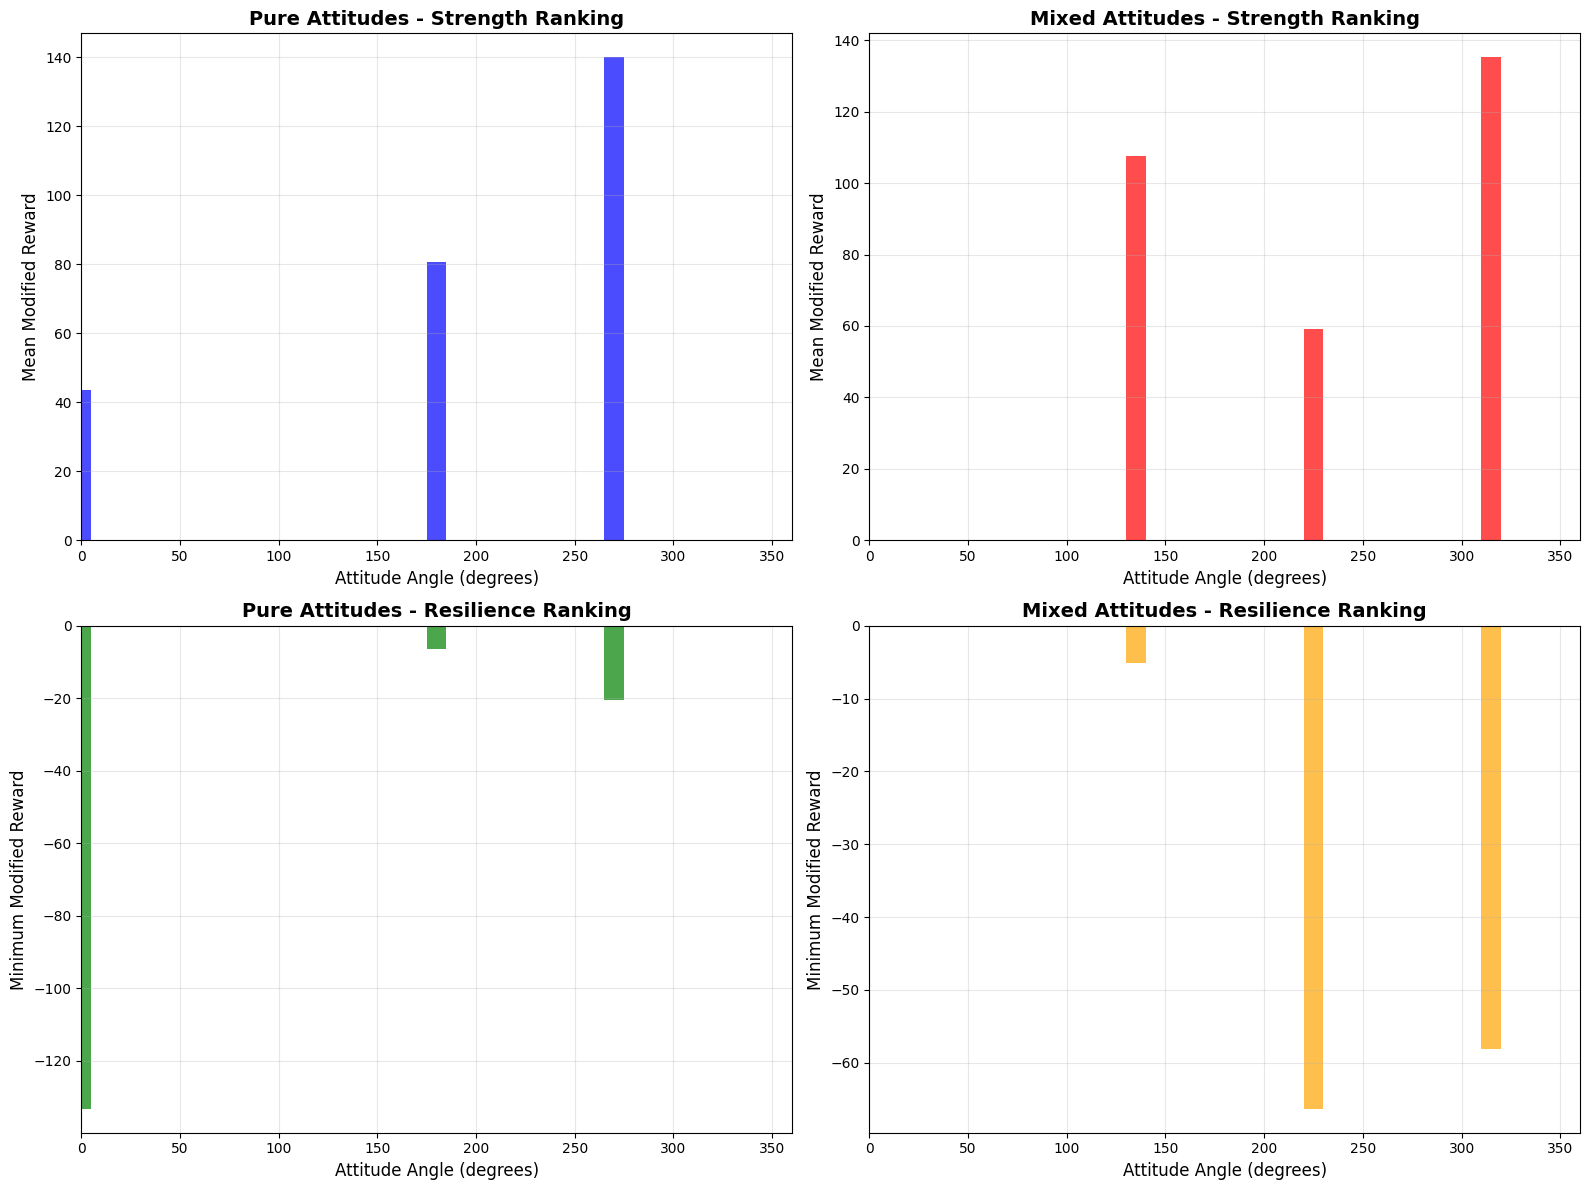

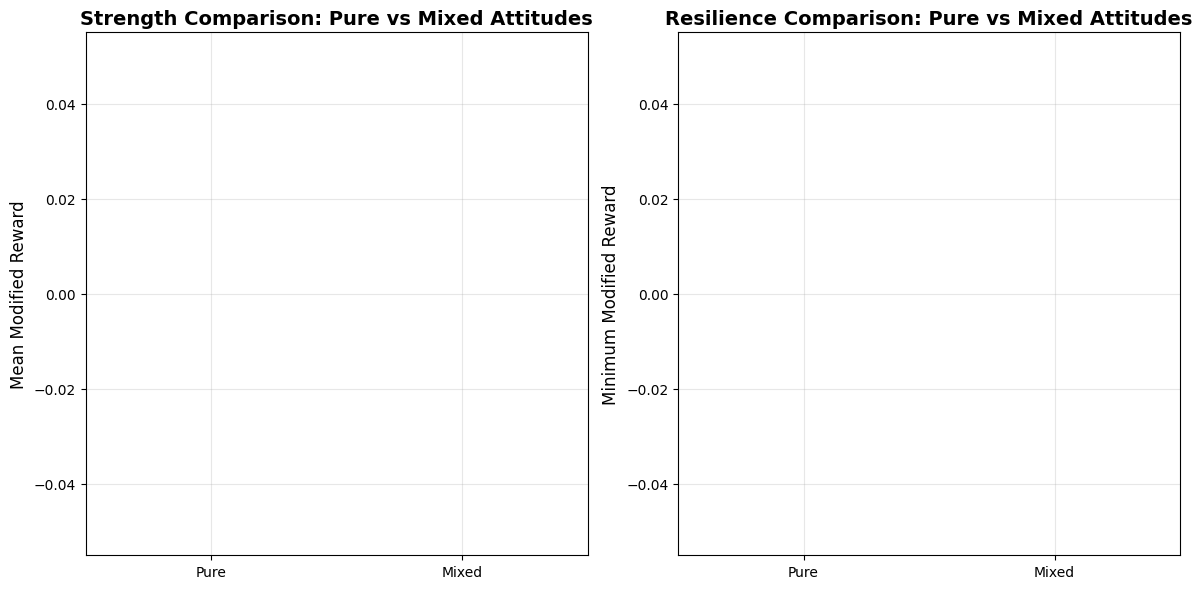


BEST PERFORMERS BY CATEGORY
BEST PURE ATTITUDES:
  Strongest: (-0.000, -1.000) (270.0°) - Mean: 139.951
  Most Resilient: (-1.000, 0.000) (180.0°) - Min: -6.385

BEST MIXED ATTITUDES:
  Strongest: (0.707, -0.707) (315.0°) - Mean: 135.180
  Most Resilient: (-0.707, 0.707) (135.0°) - Min: -5.135

OVERALL BEST:
  Strongest Overall: (-0.000, -1.000) (Pure, 270.0°) - Mean: 139.951
  Most Resilient Overall: (-0.707, 0.707) (Mixed, 135.0°) - Min: -5.135


In [50]:
# Compare strength and resilience of pure vs mixed attitudes
import numpy as np

# Create a function to convert attitude coefficients to degrees
def attitude_to_degree(alpha, beta):
    """Convert attitude coefficients to degrees (0-360)"""
    if alpha == 0 and beta == 0:
        return 0
    return np.degrees(np.arctan2(beta, alpha)) % 360

# Add degree columns to the dataframe
df['attitude_degree_agent_0'] = df.apply(lambda row: attitude_to_degree(row['alpha_1'], row['beta_1']), axis=1)
df['attitude_degree_agent_1'] = df.apply(lambda row: attitude_to_degree(row['alpha_2'], row['beta_2']), axis=1)

# Calculate modified rewards for each attitude across all combinations
attitude_performance = {}

for attitude in unique_attitudes:
    subset = df[df["attitude_key"] == attitude]
    
    # Get attitude coefficients for this combination
    alpha_1 = subset['alpha_1'].iloc[0]
    beta_1 = subset['beta_1'].iloc[0]
    alpha_2 = subset['alpha_2'].iloc[0]
    beta_2 = subset['beta_2'].iloc[0]
    
    # Calculate attitude degrees
    att_deg_0 = subset['attitude_degree_agent_0'].iloc[0]
    att_deg_1 = subset['attitude_degree_agent_1'].iloc[0]
    
    # Calculate mean rewards for each learning rate and dilemma
    for lr in subset["lr"].unique():
        lr_subset = subset[subset["lr"] == lr]
        
        # Get mean modified reward for each dilemma separately
        for dilemma in [0, 1]:
            dilemma_subset = lr_subset[lr_subset["dilemma"] == dilemma]
            
            # Get mean modified rewards for each agent
            mean_modified_reward_agent_0 = dilemma_subset["modified_reward_agent_0"].mean()
            mean_modified_reward_agent_1 = dilemma_subset["modified_reward_agent_1"].mean()
            
            # Store data for agent 0 attitude
            att_key_0 = f"({alpha_1:.3f}, {beta_1:.3f})"
            if att_key_0 not in attitude_performance:
                attitude_performance[att_key_0] = {
                    'alpha': alpha_1,
                    'beta': beta_1,
                    'degree': att_deg_0,
                    'rewards': []
                }
            attitude_performance[att_key_0]['rewards'].append(mean_modified_reward_agent_0)
            
            # Store data for agent 1 attitude
            att_key_1 = f"({alpha_2:.3f}, {beta_2:.3f})"
            if att_key_1 not in attitude_performance:
                attitude_performance[att_key_1] = {
                    'alpha': alpha_2,
                    'beta': beta_2,
                    'degree': att_deg_1,
                    'rewards': []
                }
            attitude_performance[att_key_1]['rewards'].append(mean_modified_reward_agent_1)

# Calculate statistics for each attitude and classify as pure or mixed
attitude_stats = []
for att_key, data in attitude_performance.items():
    rewards = np.array(data['rewards'])
    
    # Classify as pure or mixed (pure if one component is approximately 0)
    is_pure = (abs(data['alpha']) < 0.01) or (abs(data['beta']) < 0.01)
    attitude_type = "Pure" if is_pure else "Mixed"
    
    attitude_stats.append({
        'attitude': att_key,
        'alpha': data['alpha'],
        'beta': data['beta'],
        'degree': data['degree'],
        'type': attitude_type,
        'mean_reward': np.mean(rewards),
        'min_reward': np.min(rewards),
        'max_reward': np.max(rewards),
        'std_reward': np.std(rewards),
        'num_combinations': len(rewards)
    })

# Convert to DataFrame
attitude_df = pd.DataFrame(attitude_stats)

# Separate pure and mixed attitudes
pure_attitudes = attitude_df[attitude_df['type'] == 'Pure']
mixed_attitudes = attitude_df[attitude_df['type'] == 'Mixed']

# Sort by mean reward (strength) and min reward (resilience)
pure_strength = pure_attitudes.sort_values('mean_reward', ascending=False)
pure_resilience = pure_attitudes.sort_values('min_reward', ascending=False)
mixed_strength = mixed_attitudes.sort_values('mean_reward', ascending=False)
mixed_resilience = mixed_attitudes.sort_values('min_reward', ascending=False)

# Display results
print("="*80)
print("PURE ATTITUDES STRENGTH RANKING (by mean modified reward)")
print("="*80)
print("Rank | Attitude (α, β) | Degree | Mean Reward | Min Reward | Max Reward | Std Dev")
print("-" * 85)

for i, (_, row) in enumerate(pure_strength.iterrows(), 1):
    print(f"{i:4d} | {row['attitude']:12s} | {row['degree']:6.1f}° | {row['mean_reward']:10.3f} | {row['min_reward']:10.3f} | {row['max_reward']:10.3f} | {row['std_reward']:7.3f}")

print("\n" + "="*80)
print("MIXED ATTITUDES STRENGTH RANKING (by mean modified reward)")
print("="*80)
print("Rank | Attitude (α, β) | Degree | Mean Reward | Min Reward | Max Reward | Std Dev")
print("-" * 85)

for i, (_, row) in enumerate(mixed_strength.iterrows(), 1):
    print(f"{i:4d} | {row['attitude']:12s} | {row['degree']:6.1f}° | {row['mean_reward']:10.3f} | {row['min_reward']:10.3f} | {row['max_reward']:10.3f} | {row['std_reward']:7.3f}")

print("\n" + "="*80)
print("PURE ATTITUDES RESILIENCE RANKING (by minimum modified reward)")
print("="*80)
print("Rank | Attitude (α, β) | Degree | Min Reward | Mean Reward | Max Reward | Std Dev")
print("-" * 85)

for i, (_, row) in enumerate(pure_resilience.iterrows(), 1):
    print(f"{i:4d} | {row['attitude']:12s} | {row['degree']:6.1f}° | {row['min_reward']:10.3f} | {row['mean_reward']:10.3f} | {row['max_reward']:10.3f} | {row['std_reward']:7.3f}")

print("\n" + "="*80)
print("MIXED ATTITUDES RESILIENCE RANKING (by minimum modified reward)")
print("="*80)
print("Rank | Attitude (α, β) | Degree | Min Reward | Mean Reward | Max Reward | Std Dev")
print("-" * 85)

for i, (_, row) in enumerate(mixed_resilience.iterrows(), 1):
    print(f"{i:4d} | {row['attitude']:12s} | {row['degree']:6.1f}° | {row['min_reward']:10.3f} | {row['mean_reward']:10.3f} | {row['max_reward']:10.3f} | {row['std_reward']:7.3f}")

# Statistical comparison
print("\n" + "="*80)
print("STATISTICAL COMPARISON: PURE vs MIXED ATTITUDES")
print("="*80)

print(f"Number of pure attitudes: {len(pure_attitudes)}")
print(f"Number of mixed attitudes: {len(mixed_attitudes)}")

print(f"\nPURE ATTITUDES:")
print(f"  Mean reward - Average: {pure_attitudes['mean_reward'].mean():.3f}, Std: {pure_attitudes['mean_reward'].std():.3f}")
print(f"  Min reward - Average: {pure_attitudes['min_reward'].mean():.3f}, Std: {pure_attitudes['min_reward'].std():.3f}")
print(f"  Max reward - Average: {pure_attitudes['max_reward'].mean():.3f}, Std: {pure_attitudes['max_reward'].std():.3f}")

print(f"\nMIXED ATTITUDES:")
print(f"  Mean reward - Average: {mixed_attitudes['mean_reward'].mean():.3f}, Std: {mixed_attitudes['mean_reward'].std():.3f}")
print(f"  Min reward - Average: {mixed_attitudes['min_reward'].mean():.3f}, Std: {mixed_attitudes['min_reward'].std():.3f}")
print(f"  Max reward - Average: {mixed_attitudes['max_reward'].mean():.3f}, Std: {mixed_attitudes['max_reward'].std():.3f}")

# Create visualizations with angles on x-axis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Pure attitudes strength
ax1.bar(pure_strength['degree'], pure_strength['mean_reward'], color='blue', alpha=0.7, width=10)
ax1.set_xlabel('Attitude Angle (degrees)', fontsize=12)
ax1.set_ylabel('Mean Modified Reward', fontsize=12)
ax1.set_title('Pure Attitudes - Strength Ranking', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 360)

# Mixed attitudes strength
ax2.bar(mixed_strength['degree'], mixed_strength['mean_reward'], color='red', alpha=0.7, width=10)
ax2.set_xlabel('Attitude Angle (degrees)', fontsize=12)
ax2.set_ylabel('Mean Modified Reward', fontsize=12)
ax2.set_title('Mixed Attitudes - Strength Ranking', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 360)

# Pure attitudes resilience
ax3.bar(pure_resilience['degree'], pure_resilience['min_reward'], color='green', alpha=0.7, width=10)
ax3.set_xlabel('Attitude Angle (degrees)', fontsize=12)
ax3.set_ylabel('Minimum Modified Reward', fontsize=12)
ax3.set_title('Pure Attitudes - Resilience Ranking', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.set_xlim(0, 360)

# Mixed attitudes resilience
ax4.bar(mixed_resilience['degree'], mixed_resilience['min_reward'], color='orange', alpha=0.7, width=10)
ax4.set_xlabel('Attitude Angle (degrees)', fontsize=12)
ax4.set_ylabel('Minimum Modified Reward', fontsize=12)
ax4.set_title('Mixed Attitudes - Resilience Ranking', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.set_xlim(0, 360)

plt.tight_layout()
plt.show()

# Box plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Strength comparison
ax1.boxplot([pure_attitudes['mean_reward'], mixed_attitudes['mean_reward']], 
            labels=['Pure', 'Mixed'], patch_artist=True)
ax1.set_ylabel('Mean Modified Reward', fontsize=12)
ax1.set_title('Strength Comparison: Pure vs Mixed Attitudes', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Resilience comparison
ax2.boxplot([pure_attitudes['min_reward'], mixed_attitudes['min_reward']], 
            labels=['Pure', 'Mixed'], patch_artist=True)
ax2.set_ylabel('Minimum Modified Reward', fontsize=12)
ax2.set_title('Resilience Comparison: Pure vs Mixed Attitudes', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Best performers in each category
print("\n" + "="*80)
print("BEST PERFORMERS BY CATEGORY")
print("="*80)

print("BEST PURE ATTITUDES:")
print(f"  Strongest: {pure_strength.iloc[0]['attitude']} ({pure_strength.iloc[0]['degree']:.1f}°) - Mean: {pure_strength.iloc[0]['mean_reward']:.3f}")
print(f"  Most Resilient: {pure_resilience.iloc[0]['attitude']} ({pure_resilience.iloc[0]['degree']:.1f}°) - Min: {pure_resilience.iloc[0]['min_reward']:.3f}")

print("\nBEST MIXED ATTITUDES:")
print(f"  Strongest: {mixed_strength.iloc[0]['attitude']} ({mixed_strength.iloc[0]['degree']:.1f}°) - Mean: {mixed_strength.iloc[0]['mean_reward']:.3f}")
print(f"  Most Resilient: {mixed_resilience.iloc[0]['attitude']} ({mixed_resilience.iloc[0]['degree']:.1f}°) - Min: {mixed_resilience.iloc[0]['min_reward']:.3f}")

# Overall best
all_strength = attitude_df.sort_values('mean_reward', ascending=False)
all_resilience = attitude_df.sort_values('min_reward', ascending=False)

print("\nOVERALL BEST:")
print(f"  Strongest Overall: {all_strength.iloc[0]['attitude']} ({all_strength.iloc[0]['type']}, {all_strength.iloc[0]['degree']:.1f}°) - Mean: {all_strength.iloc[0]['mean_reward']:.3f}")
print(f"  Most Resilient Overall: {all_resilience.iloc[0]['attitude']} ({all_resilience.iloc[0]['type']}, {all_resilience.iloc[0]['degree']:.1f}°) - Min: {all_resilience.iloc[0]['min_reward']:.3f}")